# Exploratory Data Analysis of Traffic Collisions in Los Angeles, California from 2010-2022

Completed as a final project for Masters of Data Science at Berkeley - Spring 2022

Project Team: Rebecca Sun, Ben Meier, Iris Lew

Using anaconda environment from environment.yml (python=3.8 numpy pandas matplotlib seaborn plotly) 

Data downloaded on 2022-03-26 at 11:57 PDT from https://data.lacity.org/Public-Safety/Traffic-Collision-Data-from-2010-to-Present/d5tf-ez2w 

In [1]:
# Import modules
from copy import deepcopy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker

pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'pandas'

In [2]:
filename = r'Traffic_Collision_Data_from_2010_to_Present.csv'
dfin = pd.read_csv(filename)

dfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572594 entries, 0 to 572593
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   DR Number               572594 non-null  int64  
 1   Date Reported           572594 non-null  object 
 2   Date Occurred           572594 non-null  object 
 3   Time Occurred           572594 non-null  int64  
 4   Area ID                 572594 non-null  int64  
 5   Area Name               572594 non-null  object 
 6   Reporting District      572594 non-null  int64  
 7   Crime Code              572594 non-null  int64  
 8   Crime Code Description  572594 non-null  object 
 9   MO Codes                485596 non-null  object 
 10  Victim Age              489109 non-null  float64
 11  Victim Sex              563393 non-null  object 
 12  Victim Descent          562496 non-null  object 
 13  Premise Code            571632 non-null  float64
 14  Premise Description 

MO codes and their definitions can be found using the PDF given in the link. The PDF has been read and then converted into a UTF-8 csv file.

In [3]:
mo_codes_dict = pd.read_csv("Input/MO_CODES_utf8.csv", header=None)
mo_codes_dict.drop(2, axis=1, inplace=True)
mo_codes_dict.columns = ["mo_code", "code_def"]

#zero fill the mo_codes so it will be a better join with the rest of the dataset.
mo_codes_dict.mo_code = mo_codes_dict.mo_code.astype(str).str.zfill(4)
mo_codes_dict.head()

,mo_code,code_def
0,0100,Suspect Impersonate
1,0101,Aid victim
2,0102,Blind
3,0103,Crippled
4,0104,Customer


Checking to ensure that the comma is read in correctly

In [4]:
mo_codes_dict[mo_codes_dict['mo_code']=='0563']

,mo_code,code_def
257,0563,"Fetish, Other"


In [5]:
dfin.shape

(572594, 18)

Checking the columns against the data dictionary provided by the link. Judging by the shape and the column names, this matches.

Renaming the columns with snake casing and lower case.

In [6]:
dfin.columns = dfin.columns.str.replace(" ","_").str.lower()
dfin.head()

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location
0,190319651,08/24/2019,08/24/2019,450,3,Southwest,356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)"
1,190319680,08/30/2019,08/30/2019,2320,3,Southwest,355,997,TRAFFIC COLLISION,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)"
2,190413769,08/25/2019,08/25/2019,545,4,Hollenbeck,422,997,TRAFFIC COLLISION,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)"
3,190127578,11/20/2019,11/20/2019,350,1,Central,128,997,TRAFFIC COLLISION,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)"
4,190319695,08/30/2019,08/30/2019,2100,3,Southwest,374,997,TRAFFIC COLLISION,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)"


Exploring the individual columns one by one. Splitting it up by driver's license, date/time, area, crime code and code descripotion, victim information, premise information, address/street/location information, and mo_codes.

### Division of Records number

In [7]:
dfin.dr_number.astype(str).map(len).value_counts() #all the division record numbers are 9 digits long.
dfin.dr_number.value_counts().sort_values(ascending=False) #and unique.

190319651    1
190413978    1
190514836    1
190514762    1
190514716    1
            ..
220306049    1
220505617    1
221805667    1
220805532    1
221206585    1
Name: dr_number, Length: 572594, dtype: int64

**ASSUMPTION: this will be our primary key/unique record identifier**  
From the `dfin.info` output, `date_reported`, `date_occurred`, and `time_occurred` aren't treated as datetime objects. They can be coverted into datetime objects for better datetime calculations.

First check if they are all valid dates.

In [8]:
print(dfin.date_reported.dtype)
print(dfin.date_reported.apply(type).value_counts())
dfin.date_reported.str[0:2].value_counts().sort_index() #Yes. From 01-12
dfin.date_reported.str[3:5].value_counts().sort_index() #Yes. From 01-31.
dfin.date_reported.str[6:10].value_counts().sort_index() #Yes. From 2010-2022.

dfin.date_occurred.str[0:2].value_counts().sort_index() #Yes. From 01-12
dfin.date_occurred.str[3:5].value_counts().sort_index() #Yes. From 01-31.
dfin.date_occurred.str[6:10].value_counts().sort_index() #Yes. From 2010-2022.
dfin.date_reported.value_counts()

object
<class 'str'>    572594
Name: date_reported, dtype: int64


04/12/2018    235
11/17/2017    212
12/15/2017    209
10/01/2018    209
02/03/2020    208
             ... 
10/12/2021     24
03/17/2022     23
03/18/2022     19
10/10/2021     19
03/19/2022      5
Name: date_reported, Length: 4461, dtype: int64

Check if all the times are valid.

In [9]:
print(dfin.time_occurred.dtype)
dfin.time_occurred.astype(str).map(len).value_counts() #times can be 1-4 characters long.
dfin[dfin.time_occurred.astype(str).map(len)==1].time_occurred.value_counts().sort_index()
dfin[dfin.time_occurred.astype(str).map(len)==2].time_occurred.value_counts().sort_index()
dfin[dfin.time_occurred.astype(str).map(len)==3].time_occurred.value_counts().sort_index()
dfin[dfin.time_occurred.astype(str).map(len)==4].time_occurred.value_counts().sort_index()
#dfin.time_occurred.info()
dfin.time_occurred.describe()

int64


count    572594.000000
mean       1356.276709
std         598.970464
min           1.000000
25%         930.000000
50%        1430.000000
75%        1820.000000
max        2359.000000
Name: time_occurred, dtype: float64

In [10]:
# Create new datetime column (combining date_occurred and time_occurred)
time_occurred = dfin.time_occurred.apply(lambda x: '0'*(4-len(str(x))) + str(x))
dttm_occurred = dfin['date_occurred'] + time_occurred.apply(lambda x: ' ' + x[:2] + ':' + x[2:])
dfin['dttm_occurred'] = pd.to_datetime(dttm_occurred, format="%m/%d/%Y %H:%M", exact=True)
dfin.dttm_occurred.describe(datetime_is_numeric=True)

count                           572594
mean     2015-12-01 00:23:05.696602368
min                2010-01-01 00:05:00
25%                2013-03-04 02:37:30
50%                2016-02-12 22:00:00
75%                2018-08-14 09:43:45
max                2022-03-19 10:55:00
Name: dttm_occurred, dtype: object

Not all times are valid. Some have a length of 1, 2, or 3. An assumption can be made that would make these times make sense: leading 0's were dropped when this became a CSV and read into Python. To fix the problem based on this assumption, **zero-fill to have a consistent length of 4, and then add a colon on as the third character to turn this into a valid time**.

Otherwise, this looks to be accurate and using military time.

Now, checking  by `area_id`, `area_name`, and `reporting_district`.

There is a 1:1 match for area_id to area_name, but not to reporting district.

In [11]:
dfin.area_id.value_counts().sort_index()
dfin.area_name.value_counts().sort_index()
dfin[["area_id","area_name"]].value_counts().sort_index()

area_id  area_name  
1        Central        23510
2        Rampart        21589
3        Southwest      33735
4        Hollenbeck     20820
5        Harbor         21573
6        Hollywood      27599
7        Wilshire       32253
8        West LA        30039
9        Van Nuys       28473
10       West Valley    27687
11       Northeast      25595
12       77th Street    38092
13       Newton         29346
14       Pacific        29741
15       N Hollywood    30125
16       Foothill       20214
17       Devonshire     27992
18       Southeast      24848
19       Mission        25081
20       Olympic        29953
21       Topanga        24329
dtype: int64

In [12]:
dfin.reporting_district.value_counts().sort_index()

100        4
101      453
105      217
109       23
111     2239
        ... 
2189     827
2196     151
2197      57
2198      17
2199       1
Name: reporting_district, Length: 1332, dtype: int64

This makes sense as `reporting_district` is "A code used in producing reports to group data into geographic sub-areas within an area. Find LAPD Reporting Districts on the LA City GeoHub."
### Reporting Districts
Reporting Districts form the basis of crime reporting, organizing crimes into specific areas: https://geohub.lacity.org/datasets/lahub::lapd-reporting-districts/about

In [13]:
# Merge in Reporting Disctricts data:
dfrd = pd.read_csv('Input/LAPD_Reporting_Districts.csv')
print("Reporting district shape:", dfrd.shape)
dfrd.info()
dfrd.head()

Reporting district shape: (1135, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135 entries, 0 to 1134
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   FID           1135 non-null   int64  
 1   REPDIST       1135 non-null   int64  
 2   PREC          1135 non-null   int64  
 3   APREC         1135 non-null   object 
 4   BUREAU        1135 non-null   object 
 5   BASICCAR      1135 non-null   object 
 6   AREA          1135 non-null   float64
 7   PERIMETER     1135 non-null   float64
 8   SHAPE_Length  1135 non-null   float64
 9   SHAPE_Area    1135 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 88.8+ KB


,FID,REPDIST,PREC,APREC,BUREAU,BASICCAR,AREA,PERIMETER,SHAPE_Length,SHAPE_Area
0,1,1901,19,MISSION,VALLEY BUREAU,19A1,4.367178e+07,31946.355664,0.099163,0.000397
1,2,1705,17,DEVONSHIRE,VALLEY BUREAU,17A35,1.098543e+08,48888.592747,0.148847,0.001000
2,3,1902,19,MISSION,VALLEY BUREAU,19A7,3.353075e+07,26849.358596,0.081961,0.000305
3,4,1903,19,MISSION,VALLEY BUREAU,19A7,1.082610e+07,14488.784549,0.045659,0.000099
4,5,1904,19,MISSION,VALLEY BUREAU,19A7,1.730524e+07,20025.544413,0.061883,0.000157


In [14]:
print("Is REPDIST primary key for dfrd:", dfrd['REPDIST'].is_unique)
dfrd['REPDIST'].describe()

Is REPDIST primary key for dfrd: True


count    1135.000000
mean     1162.679295
std       603.568384
min       101.000000
25%       643.500000
50%      1169.000000
75%      1678.500000
max      2199.000000
Name: REPDIST, dtype: float64

In [15]:
print("number of unmatched reporting districts in dfin:", dfin[~dfin['reporting_district'].isin(dfrd['REPDIST'])].shape)
print("Date range of unmatched reporting districts:")
pd.to_datetime(dfin[~dfin['reporting_district'].isin(dfrd['REPDIST'])]['date_reported']).describe(datetime_is_numeric=True)

number of unmatched reporting districts in dfin: (1840, 19)
Date range of unmatched reporting districts:


count                             1840
mean     2014-09-19 01:40:10.434782720
min                2010-01-01 00:00:00
25%                2011-10-27 18:00:00
50%                2014-04-23 00:00:00
75%                2017-05-24 06:00:00
max                2022-03-09 00:00:00
Name: date_reported, dtype: object

### Join in reporting district data

In [16]:
# Cleanup dfrd columns before merge
dfrd.columns = ['rd_' + col.lower() for col in dfrd.columns]
dfrd.head()

,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area
0,1,1901,19,MISSION,VALLEY BUREAU,19A1,4.367178e+07,31946.355664,0.099163,0.000397
1,2,1705,17,DEVONSHIRE,VALLEY BUREAU,17A35,1.098543e+08,48888.592747,0.148847,0.001000
2,3,1902,19,MISSION,VALLEY BUREAU,19A7,3.353075e+07,26849.358596,0.081961,0.000305
3,4,1903,19,MISSION,VALLEY BUREAU,19A7,1.082610e+07,14488.784549,0.045659,0.000099
4,5,1904,19,MISSION,VALLEY BUREAU,19A7,1.730524e+07,20025.544413,0.061883,0.000157


In [17]:
# dfin.reporting_district will match to dfrd.REPDIST
dfin = pd.merge(dfin, dfrd, how="left", left_on=['reporting_district'], right_on=['rd_repdist'], validate="many_to_one")
dfin.head()

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_description,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area
0,190319651,08/24/2019,08/24/2019,450,3,Southwest,356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",2019-08-24 04:50:00,808.0,356.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.018806e+06,10591.266020,0.032011,0.000064
1,190319680,08/30/2019,08/30/2019,2320,3,Southwest,355,997,TRAFFIC COLLISION,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",2019-08-30 23:20:00,807.0,355.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.072090e+06,10823.145761,0.032805,0.000064
2,190413769,08/25/2019,08/25/2019,545,4,Hollenbeck,422,997,TRAFFIC COLLISION,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",2019-08-25 05:45:00,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064
3,190127578,11/20/2019,11/20/2019,350,1,Central,128,997,TRAFFIC COLLISION,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)",2019-11-20 03:50:00,1070.0,128.0,1.0,CENTRAL,CENTRAL BUREAU,1A29,1.534550e+06,6220.695545,0.018408,0.000014
4,190319695,08/30/2019,08/30/2019,2100,3,Southwest,374,997,TRAFFIC COLLISION,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",2019-08-30 21:00:00,829.0,374.0,3.0,SOUTHWEST,SOUTH BUREAU,3A73,8.625945e+06,12173.689427,0.036845,0.000078


### Crime code and description
Now, checking  by `crime_code` and `crime_code_description`. There is a 1:1 match where all crime_codes are 997 and these are all traffic collisions.

In [18]:
dfin.crime_code.value_counts()
dfin.crime_code_description.value_counts()
dfin[["crime_code","crime_code_description"]].value_counts()

crime_code  crime_code_description
997         TRAFFIC COLLISION         572594
dtype: int64

**ASSUMPTION: these columns do not provide any additional contextual information**

In [19]:
dfin.drop(columns=["crime_code","crime_code_description"], inplace=True)
dfin.head()

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area
0,190319651,08/24/2019,08/24/2019,450,3,Southwest,356,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",2019-08-24 04:50:00,808.0,356.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.018806e+06,10591.266020,0.032011,0.000064
1,190319680,08/30/2019,08/30/2019,2320,3,Southwest,355,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",2019-08-30 23:20:00,807.0,355.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.072090e+06,10823.145761,0.032805,0.000064
2,190413769,08/25/2019,08/25/2019,545,4,Hollenbeck,422,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",2019-08-25 05:45:00,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064
3,190127578,11/20/2019,11/20/2019,350,1,Central,128,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)",2019-11-20 03:50:00,1070.0,128.0,1.0,CENTRAL,CENTRAL BUREAU,1A29,1.534550e+06,6220.695545,0.018408,0.000014
4,190319695,08/30/2019,08/30/2019,2100,3,Southwest,374,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",2019-08-30 21:00:00,829.0,374.0,3.0,SOUTHWEST,SOUTH BUREAU,3A73,8.625945e+06,12173.689427,0.036845,0.000078


Now, checking  by `victim_age`, `victim_sex`, and `victim_descent`.
   * Looking at `victim_age`, there are 7400 where they are 99 years old. and there are 83,485 where they do not have null values.
   * Regarding `victim_sex`, according to the data dictionary, F=Female, M=Male, X=Unknown. We do not know what H and N correspond to though. There are also 9201 null values.
   * For `victim_descent`, there are 2 "-" and 10098 null values. The rest match the data dictionary.

In [20]:
# Victim age
print('Number of victim_age rows with NA:', sum(dfin.victim_age.isna()))
dfin.victim_age.value_counts().sort_index()

Number of victim_age rows with NA: 83485


10.0      56
11.0      48
12.0      67
13.0      75
14.0     113
        ... 
95.0      55
96.0      45
97.0      34
98.0      38
99.0    7400
Name: victim_age, Length: 90, dtype: int64

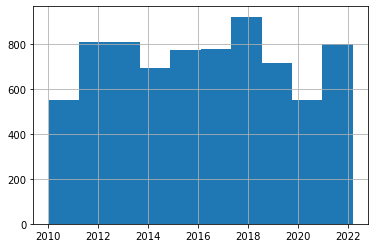

In [21]:
df99 = dfin.loc[dfin['victim_age']==99]
fig, ax = plt.subplots()
df99['dttm_occurred'].hist()
plt.show()

In [22]:
# dfin[(dfin.victim_age==99) & (dfin.victim_sex.isna()) & (dfin.victim_descent.isna())]
dfin[(dfin.victim_age.notna()) | (dfin.victim_sex.notna()) | (dfin.victim_descent.notna())].shape

(566250, 27)

In [23]:
dfin['victim_age_clean'] = dfin.victim_age.replace(99, np.nan)
dfin.victim_age_clean.value_counts(dropna=False).sort_index()

10.0       56
11.0       48
12.0       67
13.0       75
14.0      113
        ...  
95.0       55
96.0       45
97.0       34
98.0       38
NaN     90885
Name: victim_age_clean, Length: 90, dtype: int64

**ASSUMPTION: according to the data dictionary, the victim age is only a two-character field. It is possible for a victim to be over 100 years old and due to the amount of 99's in the data, we assume that 99 is a catch-all code. We will treat rows with age 99 as unknown and turn them into np.nan** 

In [24]:
# Victim sex
print('Number of victim_sex rows with NA:', sum(dfin.victim_sex.isna()))
dfin.victim_sex.value_counts().sort_index()


Number of victim_sex rows with NA: 9201


F    212946
H       156
M    334517
N        11
X     15763
Name: victim_sex, dtype: int64

**ASSUMPTION: sexes other than F/M or missing values will be considered Other/Unknown**

In [25]:
sexdict = dict(F="Female", M="Male", X="Other/Unknown", H="Other/Unknown", N="Other/Unknown")
dfin['victim_sex_clean'] = dfin.victim_sex.replace(sexdict)
dfin.victim_sex_clean.value_counts(dropna=False)


Male             334517
Female           212946
Other/Unknown     15930
NaN                9201
Name: victim_sex_clean, dtype: int64

In [26]:
# Victim descent
print("Number of null victim descents:", dfin.victim_descent.isna().sum())
dfin.victim_descent.value_counts().sort_index()

Number of null victim descents: 10098


-         2
A     20791
B     75824
C       864
D        17
F      1696
G        47
H    214080
I       178
J       334
K      4423
L         7
O     82656
P       206
S        36
U       399
V       240
W    132416
X     28124
Z       156
Name: victim_descent, dtype: int64

There are some victim descents which are '-'. This is not included in the descent dictionary provided.   
**ASSUMPTION: we will treat the 2 '-' victim descents as a miscoding. They will be treated as 'X: Unknown' instead.**

Additionally, Asians and Native Hawaiian and Pacific Islanders had more specific descent groups. In order to make it more comparable, we decided to use the groupings the US Census uses: White, Black, American Indian/Alaska Native, Asian, Native Hawaiian or Pacific Islander, and other. 

Unfortunately, this means we are still comparing race and ethnicity which are not the same.

In [27]:
# Decode victim descent
descent_dict = {"A":"Other Asian", 
                "B":"Black",
                "C":"Chinese",
                "D":"Cambodian",
                "F":"Filipino",
                "G":"Guamanian",
                "H":"Hispanic/Latin/Mexican",
                "I":"American Indian/Alaskan Native",
                "J":"Japanese",
                "K":"Korean",
                "L":"Laotian",
                "O":"Other",
                "P":"Pacific Islander",
                "S":"Samoan",
                "U":"Hawaiian",
                "V":"Vietnamese",
                "W":"White",
                "X":"Unknown",
                "Z":"Asian Indian",
                "-":"Unknown"}
descent_dict2 = {"A":"Asian", #Other Asian
                "B":"Black",
                "C":"Asian", #Chinese
                "D":"Asian", #Cambodian
                "F":"Native Hawaiian/Pacific Islander", #Filipino
                "G":"Native Hawaiian/Pacific Islander", #Guamanian
                "H":"Hispanic/Latin/Mexican",
                "I":"American Indian/Alaskan Native",
                "J":"Asian", #Japanese
                "K":"Asian", #Korean
                "L":"Asian", #Laotian
                "O":"Other",
                "P":"Native Hawaiian/Pacific Islander", #Pacific Islander
                "S":"Native Hawaiian/Pacific Islander", #Samoan
                "U":"Native Hawaiian/Pacific Islander", #Hawaiian
                "V":"Asian", #Vietnamese
                "W":"White",
                "X":"Unknown",
                "Z":"Asian", #Asian Indian
                "-":"Unknown"}
dfin['victim_descent_clean'] = dfin.victim_descent.replace(descent_dict2)
dfin['victim_descent_clean'].value_counts(dropna=False).sort_index()

American Indian/Alaskan Native         178
Asian                                26832
Black                                75824
Hispanic/Latin/Mexican              214080
Native Hawaiian/Pacific Islander      2384
Other                                82656
Unknown                              28126
White                               132416
NaN                                  10098
Name: victim_descent_clean, dtype: int64

**ASSUMPTION: Due to the transcribed nature of this data, we assume that if victim age, sex, and origin are NaN, then there was no victim for this collision. If any of these values are not NaN, then we assume that there was a victim, but one or two of their values (e.g. age, or origin and sex) was not collected. A column would be added to denote the presence of a victim based on the original column values of victim age, victim sex, and victim descent.** 

In [28]:
print("Number of rows with all 3 victim columns missing", dfin[(dfin.victim_age_clean.isna()) & (dfin.victim_sex_clean.isna()) & (dfin.victim_descent_clean.isna())].shape)
print("Number of rows with at least one victim column (cleaned) filled out", dfin[(dfin.victim_age_clean.notna()) | (dfin.victim_sex_clean.notna()) | (dfin.victim_descent_clean.notna())].shape)
print("Number of rows with at least one victim column (original) filled out", dfin[(dfin.victim_age.notna()) | (dfin.victim_sex.notna()) | (dfin.victim_descent.notna())].shape)

Number of rows with all 3 victim columns missing (6659, 30)
Number of rows with at least one victim column (cleaned) filled out (565935, 30)
Number of rows with at least one victim column (original) filled out (566250, 30)


In [29]:
dfin["victim"] = (dfin.victim_age.notna()) | (dfin.victim_sex.notna()) | (dfin.victim_descent.notna())
dfin["victim"].value_counts()

True     566250
False      6344
Name: victim, dtype: int64

We decided to check the date reported and date occurred columns against each other. Date reported should always be after date occurred.

In [30]:
# Convert the date column to a datetime object
dfin["dreport_new"] = pd.to_datetime(dfin.date_reported)

# Take the difference between the occurred and reported dates.
dfin["date_rep_occ_diff"] = dfin["dreport_new"].dt.date - dfin.dttm_occurred.dt.date

dfin["date_rep_occ_diff"].value_counts().sort_values(ascending=False)

# Change to integer for plotting
dfin["date_rep_occ_diff_int"] = (dfin["date_rep_occ_diff"].astype("int64")/(86400000000000))
dfin["date_rep_occ_diff_int"].value_counts()

0.0      406419
1.0      111940
2.0       16683
3.0        7813
4.0        5139
          ...  
292.0         1
255.0         1
399.0         1
505.0         1
303.0         1
Name: date_rep_occ_diff_int, Length: 447, dtype: int64

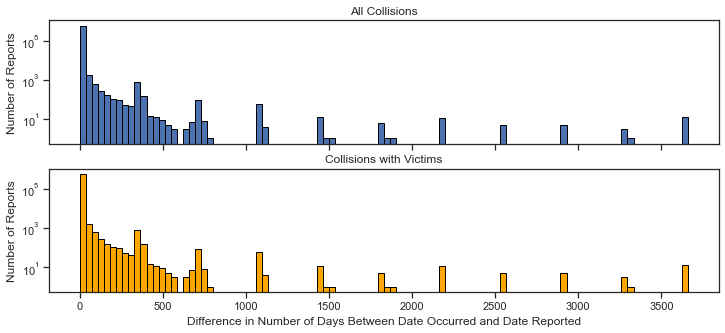

In [31]:
sns.set_theme(style="whitegrid")
sns.set_style("ticks")

figure, ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(12,5))
ax[0].hist(dfin["date_rep_occ_diff_int"],bins=100, edgecolor="black")
ax[0].set_yscale("log")
ax[0].set_ylabel("Number of Reports")
ax[0].set_title("All Collisions")
ax[0].grid(False)

ax[1].hist(dfin[dfin["victim"]]["date_rep_occ_diff_int"],bins=100, edgecolor="black", color="orange")
ax[1].set_yscale("log")
ax[1].set_ylabel("Number of Reports")
ax[1].set_title("Collisions with Victims")
ax[1].set_xlabel("Difference in Number of Days Between Date Occurred and Date Reported")
ax[1].grid(False)

figure.savefig("Output/date_plots/Date_Difference.png")

The DMV indicates that a report should be filed within 10 days if there were over $1,000 in property damage or someone was injured. If there were victims, we would expect the victims or the victims' families to report it earlier. Hence, while most of the collisions obeyed this, there were some which took years.

In [32]:
dfin[dfin.date_rep_occ_diff_int>365]

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,victim_age_clean,victim_sex_clean,victim_descent_clean,victim,dreport_new,date_rep_occ_diff,date_rep_occ_diff_int
196,191221593,08/31/2019,08/30/2010,2311,12,77th Street,1239,3101 3401 3701 3006 3030 3602 3801 1218,16.0,M,H,101.0,STREET,SLAUSON AV,FIGUEROA ST,"(33.9892, -118.2827)",2010-08-30 23:11:00,906.0,1239.0,12.0,77TH STREET,SOUTH BUREAU,12A49,9.751333e+06,13919.033798,0.043376,0.000088,16.0,Male,Hispanic/Latin/Mexican,True,2019-08-31,3288 days,3288.0
972,191113329,07/09/2019,07/09/2016,1115,11,Northeast,1157,3101 3401 3701 3004 3030 3036,40.0,M,H,101.0,STREET,LANKERSHIM BL,CAMARILLO,"(34.0974, -118.2367)",2016-07-09 11:15:00,460.0,1157.0,11.0,NORTHEAST,CENTRAL BUREAU,11A1,5.736538e+06,9977.062297,0.030444,0.000052,40.0,Male,Hispanic/Latin/Mexican,True,2019-07-09,1095 days,1095.0
1566,191815857,07/14/2019,07/13/2018,2350,18,Southeast,1861,4025 3037 3028 3030,43.0,M,H,102.0,SIDEWALK,VERMONT,IMPERIAL HY,"(33.931, -118.2916)",2018-07-13 23:50:00,988.0,1861.0,18.0,SOUTHEAST,SOUTH BUREAU,18A97,7.281642e+06,10780.414687,0.032632,0.000066,43.0,Male,Hispanic/Latin/Mexican,True,2019-07-14,366 days,366.0
2427,191014576,09/06/2019,09/06/2017,500,10,West Valley,1044,3008 3037 3030 3025 3101 3401 3701 4026,38.0,M,H,101.0,STREET,RESEDA BL,BURBANK BL,"(34.1765, -118.5333)",2017-09-06 05:00:00,308.0,1044.0,10.0,WEST VALLEY,VALLEY BUREAU,10A83,4.444065e+06,8790.716922,0.025854,0.000040,38.0,Male,Hispanic/Latin/Mexican,True,2019-09-06,730 days,730.0
3197,190218697,09/18/2019,05/02/2018,1325,2,Rampart,221,3101 3401 3701 3004 3026,14.0,M,H,101.0,STREET,VERMONT AV,OAKWOOD AV,"(34.0777, -118.2917)",2018-05-02 13:25:00,540.0,221.0,2.0,RAMPART,CENTRAL BUREAU,2A1,2.618138e+06,7263.298694,0.022887,0.000024,14.0,Male,Hispanic/Latin/Mexican,True,2019-09-18,504 days,504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571258,220404373,01/13/2022,01/11/2021,2110,4,Hollenbeck,407,3101 3401 3701 4013 3037 3034 3033 0605 3004 3026,19.0,M,H,101.0,STREET,HUNTINGTON DR,MONTEREY RD,"(34.0862, -118.1875)",2021-01-11 21:10:00,488.0,407.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A3,9.017442e+06,18087.595116,0.054064,0.000082,19.0,Male,Hispanic/Latin/Mexican,True,2022-01-13,367 days,367.0
571505,220605065,01/25/2022,01/22/2021,20,6,Hollywood,646,3003 3026 3029 4027 3035 3037 3101 3701 3401,32.0,F,B,101.0,STREET,SELMA AV,CAHUENGA BL,"(34.0998, -118.3295)",2021-01-22 00:20:00,467.0,646.0,6.0,HOLLYWOOD,WEST BUREAU,6A63,6.906816e+06,12495.406472,0.038369,0.000063,32.0,Female,Black,True,2022-01-25,368 days,368.0
571745,221305322,01/28/2022,01/28/2020,1715,13,Newton,1372,0605 3006 3028 3039 4024 3801 3101 3401 3701,29.0,F,H,101.0,STREET,52ND PL,AVALON BL,"(33.9953, -118.2652)",2020-01-28 17:15:00,890.0,1372.0,13.0,NEWTON,CENTRAL BUREAU,13A85,5.827067e+06,9699.034995,0.029575,0.000053,29.0,Female,Hispanic/Latin/Mexican,True,2022-01-28,731 days,731.0
572388,221305826,02/05/2022,02/05/2012,1605,13,Newton,1321,3004 3026 3029 3101 4024 0605 3401 3701 3037 3033,18.0,M,H,101.0,STREET,FLOWER,20TH ST,"(34.0324, -118.2717)",2012-02-05 16:05:00,1110.0,1321.0,13.0,NEWTON,CENTRAL BUREAU,13A13,9.018995e+06,12059.476653,0.036666,0.000082,18.0,Male,Hispanic/Latin/Mexican,True,2022-02-05,3653 days,3653.0


**ASSUMPTION: We assume these to be transcription errors and have to make the assumption that the `date_occurred` and `time_occurred` columns are correct.**

Now, checking  by `premise_code` and `premise_description`. There is a 1:1 match except for 418 which has no description. Most collisions occur on streets, parking lots, and sidewalks. There is a factor of 10 difference beetween the top 3.

In [33]:
dfin[["premise_code","premise_description"]].value_counts()  # length = 120
# Export premise descriptions to csv for inspection:
# dfin[["premise_code","premise_description"]].drop_duplicates().sort_values(['premise_description']).to_csv('premise_desc.csv', index=False)

premise_code  premise_description               
101.0         STREET                                545362
108.0         PARKING LOT                            18062
102.0         SIDEWALK                                3108
103.0         ALLEY                                   1022
104.0         DRIVEWAY                                 986
                                                     ...  
405.0         CLOTHING STORE                             1
407.0         HARDWARE/BUILDING SUPPLY                   1
408.0         AUTO SUPPLY STORE*                         1
411.0         PET STORE                                  1
970.0         MTA - GOLD LINE - SOUTHWEST MUSEUM         1
Length: 120, dtype: int64

Now, checking  by `address`, `cross_street`, and `location`. 
   * `address` can be cleaned up by separating number and street name. There is an address for every record. Can do with a bit of further cleaning for formatting to address white space if desired.
   * `cross_street` looks clean for the most part. Can do with a bit of further cleaning for formatting to address white space if desired. There are 27,280 records without a cross street.
   * For `location`, there are 770 records with a location of (0.0, 0.0). The rest look within reason. There is a location for every row.

In [34]:
dfin.location.value_counts(dropna=False).sort_index()

(0.0, 0.0)              770
(33.3427, -118.3258)      2
(33.7065, -118.2879)      1
(33.7065, -118.2928)     20
(33.7065, -118.2929)      3
                       ... 
(34.3797, -118.5286)      1
(34.5957, -118.1784)      5
(34.6012, -118.1605)      1
(34.6903, -118.3053)      1
(34.692, -118.1746)       1
Name: location, Length: 50256, dtype: int64

**ASSUMPTION: We assumed that if the location XY coordination is (0,0), the location is invalid/non-reported,**
**hence, it is removed from the final dataset for geographical evaluation**

In [35]:
dfin.address.value_counts()
print("address:", dfin[dfin.address.str.fullmatch(r"\s*")].shape[0])

dfin.cross_street.value_counts()
print("cross_street:", dfin.cross_street.isnull().sum())

dfin.location.value_counts().sort_index()
print("location:", dfin[dfin.location=="0.0, 0.0"].shape[0])

address: 0
cross_street: 27280
location: 0


In [36]:
print("number of unique address:", dfin.address.str.strip().value_counts(dropna=True).sort_index().shape)

number of unique address: (28224,)


In [37]:
dfin[(dfin['location']=='(0.0, 0.0)') & (dfin['address']!="00")].head()
dfin[(dfin['location']=='(0.0, 0.0)') & (dfin['address']!="00")].shape

(751, 34)

In [38]:
dfin[(dfin['location']=='(0.0, 0.0)')].shape

(770, 34)

In [39]:
dfin['location_clean'] = dfin.location.replace('0.0, 0.0', np.nan)
dfin.location_clean.value_counts(dropna=False).sort_index()

(0.0, 0.0)              770
(33.3427, -118.3258)      2
(33.7065, -118.2879)      1
(33.7065, -118.2928)     20
(33.7065, -118.2929)      3
                       ... 
(34.3797, -118.5286)      1
(34.5957, -118.1784)      5
(34.6012, -118.1605)      1
(34.6903, -118.3053)      1
(34.692, -118.1746)       1
Name: location_clean, Length: 50256, dtype: int64

### Split location into lat and long

In [40]:
dfin['location'] = dfin['location'].map(lambda x: x.lstrip('(').rstrip(')'))
dfin[['latitude', 'longitude']] = dfin['location'].str.split(',', expand=True).apply(pd.to_numeric)
dfin.latitude.value_counts(sort=True, ascending=False)

print('longitude min: ',min(dfin[dfin['longitude']!=0]['longitude']))
print('longitude max: ',max(dfin[dfin['longitude']!=0]['longitude']))
print('latitude min: ',min(dfin[dfin['latitude']!=0]['latitude']))
print('latitude max: ',max(dfin['latitude']))


longitude min:  -118.6673
longitude max:  -117.7059
latitude min:  33.3427
latitude max:  34.692


Now, checking the `mo_codes`. Creating a separate copy and then turning the dataset long in order to just look at mo_codes by themself.

In [41]:
dfin_copy = deepcopy(dfin)
dfin_copy[["mo_code_0",
           "mo_code_1", 
           "mo_code_2",
           "mo_code_3",
           "mo_code_4",
           "mo_code_5",
           "mo_code_6",
           "mo_code_7",
           "mo_code_8",
           "mo_code_9"]] = dfin_copy["mo_codes"].str.split(" ", expand=True)

dfin_copy.head()

dfin_mo_long = pd.melt(dfin_copy, id_vars=["dr_number"], value_vars = ["mo_code_0",
                                                                       "mo_code_1",
                                                                       "mo_code_2",
                                                                       "mo_code_3",
                                                                       "mo_code_4",
                                                                       "mo_code_5",
                                                                       "mo_code_6",
                                                                       "mo_code_7",
                                                                       "mo_code_8",
                                                                       "mo_code_9",])
dfin_mo_long.columns = ["dr_number","orig_var","mo_code"]
dfin_mo_long.mo_code.value_counts() # 333 mo_codes, max is 3101 with 419587
dfin_mo_long.shape #(5725940,3)

# check what happens to the "None" values when they are melted. 
# 190319651 only has 3036, 3004, 3026, 3101, 4003
dfin_mo_long[dfin_mo_long.dr_number==190319651]
dfin_mo_long.dropna(subset=["mo_code"], inplace=True)
dfin_mo_long.shape #3182316
dfin_mo_long[dfin_mo_long.dr_number==190319651] #correct
dfin_mo_long.mo_code.value_counts()

dfin_mo_long[["dr_number","mo_code"]].value_counts() #there are unique dr_numbers to mo_codes.

dr_number  mo_code
100101322  1402       1
180809040  3037       1
180809017  4027       1
180809023  3006       1
           3028       1
                     ..
151312453  3008       1
           3025       1
           3101       1
           3401       1
222106942  4026       1
Length: 3182316, dtype: int64

Check if every `mo_code` found in the dataset exists in the mo_code_dictionary. Not all of them exist in the dictionary. Should we do more research?

In [42]:
dfin_mo_desc = pd.merge(dfin_mo_long,mo_codes_dict, left_on="mo_code", right_on="mo_code", how="left")
dfin_mo_desc.shape # (5725940, 4)

dfin_mo_desc[["mo_code","code_def"]].value_counts()
dfin_mo_desc.code_def.isnull().sum() #841 are NaN values.
dfin_mo_desc[dfin_mo_desc.code_def.isnull()].mo_code.value_counts()

0947    731
3031     71
3063     20
3064     16
1505      1
2053      1
1528      1
Name: mo_code, dtype: int64

**ASSUMPTION: There are 7 MO codes which were not found in the MO_CODES.pdf file. We will assume these were mistyped or mistranscribed. We will move forward by assuming the MO code is NaN.**

We decided to filter out the 2022 data to make comparisons across complete years, months, and dates.

In [43]:
#filtering out 2022 data
dfin = dfin[dfin.date_occurred.str[6:]!="2022"]

print(f'Min of Date Occurred: {dfin.date_occurred.min()}')
print(f'Max of Date Occurred: {dfin.date_occurred.max()}')
print("")
print(f'Min of Date Reported: {dfin.date_occurred.min()}')
print(f'Max of Date Reported: {dfin.date_occurred.max()}')

Min of Date Occurred: 01/01/2010
Max of Date Occurred: 12/31/2021

Min of Date Reported: 01/01/2010
Max of Date Reported: 12/31/2021


Cleaning up the data and setting up final data frame for analysis and visualizations.

In [44]:
dfin_mo_desc.head()

,dr_number,orig_var,mo_code,code_def
0,190319651,mo_code_0,3036,T/C - At Intersection - Yes
1,190319680,mo_code_0,3037,T/C - At Intersection - No
2,190413769,mo_code_0,3101,T/C - PCF (A) In the Narrative
3,190127578,mo_code_0,0605,Traffic Accident/Traffic related incident
4,190319695,mo_code_0,0605,Traffic Accident/Traffic related incident


# Final Dataset
We are now left with our final dataframe.

In [45]:
print("Shape:", dfin.shape)
dfin.head()

Shape: (569403, 37)


,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,victim_age_clean,victim_sex_clean,victim_descent_clean,victim,dreport_new,date_rep_occ_diff,date_rep_occ_diff_int,location_clean,latitude,longitude
0,190319651,08/24/2019,08/24/2019,450,3,Southwest,356,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"34.0255, -118.3002",2019-08-24 04:50:00,808.0,356.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.018806e+06,10591.266020,0.032011,0.000064,22.0,Male,Hispanic/Latin/Mexican,True,2019-08-24,0 days,0.0,"(34.0255, -118.3002)",34.0255,-118.3002
1,190319680,08/30/2019,08/30/2019,2320,3,Southwest,355,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"34.0256, -118.3089",2019-08-30 23:20:00,807.0,355.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.072090e+06,10823.145761,0.032805,0.000064,30.0,Female,Hispanic/Latin/Mexican,True,2019-08-30,0 days,0.0,"(34.0256, -118.3089)",34.0256,-118.3089
2,190413769,08/25/2019,08/25/2019,545,4,Hollenbeck,422,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"34.0738, -118.2078",2019-08-25 05:45:00,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064,NaN,Male,Unknown,True,2019-08-25,0 days,0.0,"(34.0738, -118.2078)",34.0738,-118.2078
3,190127578,11/20/2019,11/20/2019,350,1,Central,128,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"34.0492, -118.2391",2019-11-20 03:50:00,1070.0,128.0,1.0,CENTRAL,CENTRAL BUREAU,1A29,1.534550e+06,6220.695545,0.018408,0.000014,21.0,Male,Hispanic/Latin/Mexican,True,2019-11-20,0 days,0.0,"(34.0492, -118.2391)",34.0492,-118.2391
4,190319695,08/30/2019,08/30/2019,2100,3,Southwest,374,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"34.0108, -118.3182",2019-08-30 21:00:00,829.0,374.0,3.0,SOUTHWEST,SOUTH BUREAU,3A73,8.625945e+06,12173.689427,0.036845,0.000078,49.0,Male,Black,True,2019-08-30,0 days,0.0,"(34.0108, -118.3182)",34.0108,-118.3182


## Location, location, location

Location where most collisions occur:

- Which streets or intersections have the most collisions reported? 
- What type of structure or location where the most incidents took place?
- Which precincts received the most collisions reports, accounting for area (see reporting districts additional column rd_area)

In [46]:
dfin.head(5)

,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,victim_age_clean,victim_sex_clean,victim_descent_clean,victim,dreport_new,date_rep_occ_diff,date_rep_occ_diff_int,location_clean,latitude,longitude
0,190319651,08/24/2019,08/24/2019,450,3,Southwest,356,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"34.0255, -118.3002",2019-08-24 04:50:00,808.0,356.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.018806e+06,10591.266020,0.032011,0.000064,22.0,Male,Hispanic/Latin/Mexican,True,2019-08-24,0 days,0.0,"(34.0255, -118.3002)",34.0255,-118.3002
1,190319680,08/30/2019,08/30/2019,2320,3,Southwest,355,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"34.0256, -118.3089",2019-08-30 23:20:00,807.0,355.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.072090e+06,10823.145761,0.032805,0.000064,30.0,Female,Hispanic/Latin/Mexican,True,2019-08-30,0 days,0.0,"(34.0256, -118.3089)",34.0256,-118.3089
2,190413769,08/25/2019,08/25/2019,545,4,Hollenbeck,422,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"34.0738, -118.2078",2019-08-25 05:45:00,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064,NaN,Male,Unknown,True,2019-08-25,0 days,0.0,"(34.0738, -118.2078)",34.0738,-118.2078
3,190127578,11/20/2019,11/20/2019,350,1,Central,128,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"34.0492, -118.2391",2019-11-20 03:50:00,1070.0,128.0,1.0,CENTRAL,CENTRAL BUREAU,1A29,1.534550e+06,6220.695545,0.018408,0.000014,21.0,Male,Hispanic/Latin/Mexican,True,2019-11-20,0 days,0.0,"(34.0492, -118.2391)",34.0492,-118.2391
4,190319695,08/30/2019,08/30/2019,2100,3,Southwest,374,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"34.0108, -118.3182",2019-08-30 21:00:00,829.0,374.0,3.0,SOUTHWEST,SOUTH BUREAU,3A73,8.625945e+06,12173.689427,0.036845,0.000078,49.0,Male,Black,True,2019-08-30,0 days,0.0,"(34.0108, -118.3182)",34.0108,-118.3182


#### Assumption: `address value` = '00' and `cross_name` = 'nan' is not a cross street, hence, can be removed

In [47]:
# remove the white space in addresses and cross streets

dfin['address'] = dfin.address.apply(lambda x: str(x))
dfin['address'] = dfin.address.apply(lambda x: " ".join(x.split()))

dfin['cross_street'] = dfin.cross_street.apply(lambda x: str(x))   
dfin['cross_street'] = dfin.cross_street.apply(lambda x: " ".join(x.split()))

# create a columns: intersection, joining the address and cross street with ','
dfin['intersection'] = dfin['address'] + ", " + dfin['cross_street']
len(dfin['intersection']) #len = 572594, drop 00, nan
dfin['intersection'] = dfin['intersection'][dfin['intersection'] != '00, nan']
dfin['intersection'].value_counts()

SHERMAN WY, SEPULVEDA BL    283
TAMPA AV, NORDHOFF ST       270
SHERMAN WY, WOODMAN AV      256
SHERMAN WY, WHITSETT AV     247
VAN NUYS BL, ROSCOE BL      246
                           ... 
61ST, FIGUEROA                1
FLORENCE, W HOOVER            1
4500 S HOOVER, nan            1
1100 W 53RD ST, nan           1
FLOWER, 20TH ST               1
Name: intersection, Length: 141137, dtype: int64

In [48]:
dfin_intersection= dfin['intersection'].reset_index()
dfin_intersection_descending = dfin_intersection.groupby('intersection').count().sort_values(by=['index'], ascending=False).reset_index().rename(columns={'index':'count'})

# top 10 most dangerous intersections
top_ten_intersection = dfin_intersection_descending.iloc[:10]
top_ten_intersection

,intersection,count
0,"SHERMAN WY, SEPULVEDA BL",283
1,"TAMPA AV, NORDHOFF ST",270
2,"SHERMAN WY, WOODMAN AV",256
3,"SHERMAN WY, WHITSETT AV",247
4,"VAN NUYS BL, ROSCOE BL",246
5,"SLAUSON AV, WESTERN AV",237
6,"ROSCOE BL, VAN NUYS BL",231
7,"BURBANK BL, SEPULVEDA BL",218
8,"MANCHESTER AV, FIGUEROA ST",216
9,"SHERMAN WY, BELLAIRE AV",208


Text(0.5, 1.0, 'Top 10 Most Dangerous Intersections')

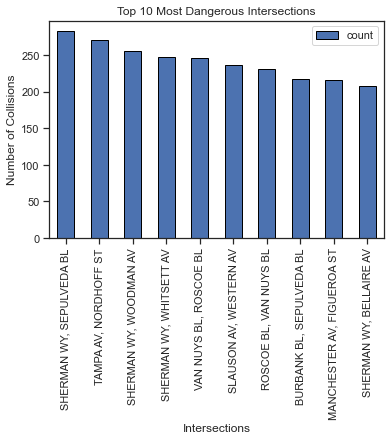

In [49]:
# Whats the most dangerous intersection in LA?
dfin_intersection= dfin['intersection'].reset_index()
dfin_intersection_descending = dfin_intersection.groupby('intersection').count().sort_values(by=['index'], ascending=False).reset_index().rename(columns={'index':'count'})

# top 10 most dangerous intersections
top_ten_intersection = dfin_intersection_descending.iloc[:10]
top_ten_intersection

top_ten_intersection.plot(x='intersection',kind="bar",edgecolor="black", figsize=(6,4))

plt.ylabel("Number of Collisions")
plt.xlabel("Intersections")
plt.xticks(rotation=90)
plt.title("Top 10 Most Dangerous Intersections")

77th Street    37820
Southwest      33548
Wilshire       32110
N Hollywood    29973
West LA        29915
Olympic        29814
Pacific        29607
Newton         29152
Van Nuys       28334
Devonshire     27842
West Valley    27515
Hollywood      27486
Northeast      25460
Mission        24923
Southeast      24662
Topanga        24206
Central        23363
Rampart        21467
Harbor         21432
Hollenbeck     20696
Foothill       20078
Name: area_name, dtype: int64

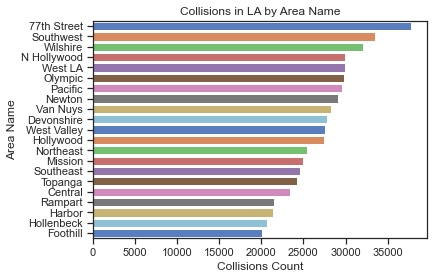

In [50]:
# collisions by area name in descending order

fig,ax = plt.subplots(figsize=(6,4))
descending_order = dfin['area_name'].value_counts().sort_values(ascending=False).index
sns.countplot(data=dfin,y="area_name",order=descending_order, palette='muted')
ax.set_title('Collisions in LA by Area Name')
plt.xlabel("Collisions Count")
plt.ylabel("Area Name")

dfin['area_name'].value_counts()

In [51]:
# use the Premise Description field to look at different locations of collisions, we can see that parking lot is the second most common type of collisions after street

premise = dfin['premise_description'].value_counts(normalize = True).reset_index().rename(columns={'index':'premise', 'premise_description':'pct'}).head(3)
premise


,premise,pct
0,STREET,0.954081
1,PARKING LOT,0.031669
2,SIDEWALK,0.005344


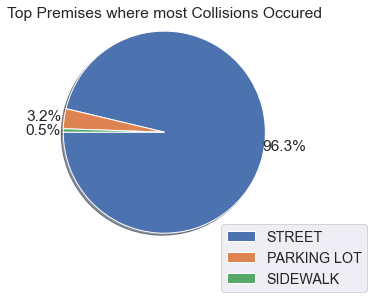

In [52]:
sns.set_style('darkgrid', {'xtick.bottom': True, 'ytick.left': True})
sns.set_palette('Spectral')
sns.set(font_scale=1.3)

premise_label = list(premise.premise)
explode = [0, 0.15, 0.15, 0.15, 0.15]

plt.figure(figsize=(4,4))    
plt.pie(premise['pct'], labels = None, shadow = True, autopct='%1.1f%%', pctdistance = 1.2, startangle=180)
plt.title('Top Premises where most Collisions Occured')
plt.legend(premise_label,bbox_to_anchor=(0.72,0.11), loc="upper left")
plt.ylabel("")
plt.axis('equal')
plt.show()

Text(0, 0.5, 'Area Name')

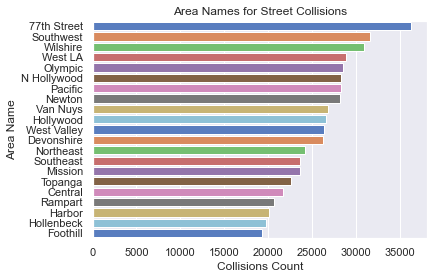

In [53]:
# Cross check the area_name and the premise location: Street
premise_street = dfin[dfin['premise_description'] == 'STREET']
sns.set(font_scale=1.0)

fig,ax = plt.subplots(figsize=(6,4))
descending_order = premise_street['area_name'].value_counts().sort_values(ascending=False).index
sns.countplot(data=premise_street,y="area_name",order=descending_order, palette='muted')
ax.set_title('Area Names for Street Collisions')
plt.xlabel("Collisions Count")
plt.ylabel("Area Name")

Text(0, 0.5, 'Area Name')

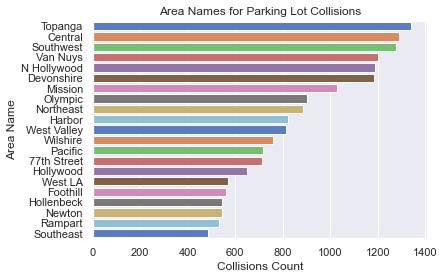

In [54]:
# Cross check the area_name and the premise location: Parking lot
premise_parking = dfin[dfin['premise_description'] == 'PARKING LOT']
sns.set(font_scale=1.0)

fig,ax = plt.subplots(figsize=(6,4))
descending_order = premise_parking['area_name'].value_counts().sort_values(ascending=False).index
sns.countplot(data=premise_parking,y="area_name",order=descending_order, palette='muted')
ax.set_title('Area Names for Parking Lot Collisions')
plt.xlabel("Collisions Count")
plt.ylabel("Area Name")

In [55]:
# What times do accidents occur at these intersections? the top 10 intersections with the most accidents

intersection = list(top_ten_intersection['intersection'])
time_intersection = dfin[['time_occurred', 'intersection']]
time_top_ten_intersection = time_intersection[(time_intersection.intersection.isin(intersection))].reset_index()
time_top_ten_intersection.head(10)

,index,time_occurred,intersection
0,426,1630,"ROSCOE BL, VAN NUYS BL"
1,464,1345,"SHERMAN WY, SEPULVEDA BL"
2,534,2215,"SHERMAN WY, BELLAIRE AV"
3,1139,1520,"SHERMAN WY, WHITSETT AV"
4,1800,1930,"BURBANK BL, SEPULVEDA BL"
5,1826,1724,"SHERMAN WY, WOODMAN AV"
6,2145,2150,"SHERMAN WY, SEPULVEDA BL"
7,2280,2155,"SHERMAN WY, SEPULVEDA BL"
8,2364,1923,"VAN NUYS BL, ROSCOE BL"
9,2378,1900,"TAMPA AV, NORDHOFF ST"


In [56]:
intersection = list(top_ten_intersection['intersection'])
time_intersection = dfin[['time_occurred', 'intersection']]
time_top_ten_intersection = time_intersection[(time_intersection.intersection.isin(intersection))].reset_index()
time_top_ten_intersection.head(10)
time_top_ten_intersection_zoom = time_top_ten_intersection[(time_top_ten_intersection['time_occurred']>=1200)&
                                                             (time_top_ten_intersection['time_occurred']<=1800)]

time_top_ten_intersection_zoom.describe()

,index,time_occurred
count,1121.000000,1121.000000
mean,305587.723461,1479.694023
std,163981.683832,175.228224
min,426.000000,1200.000000
25%,159047.000000,1330.000000
50%,329213.000000,1500.000000
75%,439481.000000,1630.000000
max,569200.000000,1800.000000


In [57]:
sns.set_style('darkgrid', {'xtick.bottom': True, 'ytick.left': True})
palette=sns.color_palette('Blues', n_colors=10)
palette.reverse()
sns.set(font_scale=1.1)

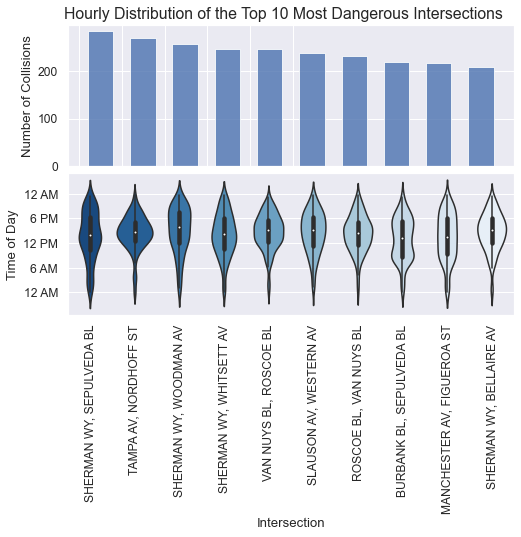

In [58]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Hourly Distribution of the Top 10 Most Dangerous Intersections')
fig.set_figheight(5)
fig.set_figwidth(8)

plt.subplot(211)
ax1 = plt.bar(range(len(top_ten_intersection['count'])), top_ten_intersection['count'], width=0.6, align='center', alpha=0.8)
plt.ylabel("Number of Collisions")
plt.xticks(np.arange(-0.5, 5.5, 1.01),[], rotation=90)



plt.subplot(212)
ax2 = sns.violinplot(data=time_top_ten_intersection, x='intersection', y='time_occurred', order=intersection, palette=palette)
ax2.set_yticks([0, 600, 1200, 1800, 2400])
ax2.set_yticklabels(['12 AM', '6 AM', '12 PM', '6 PM', '12 AM'])
ax2.set_xlabel('Intersection')
ax2.set_ylabel('Time of Day')
ax2.set_xticklabels(intersection, rotation=90)
plt.subplots_adjust(top=0.93, hspace=0.05)
plt.show()

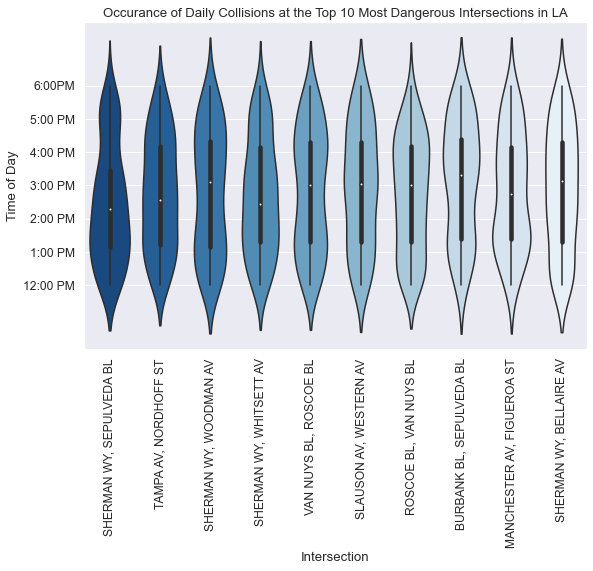

In [59]:
sns.set_style('darkgrid', {'xtick.bottom': True, 'ytick.left': True})
palette=sns.color_palette('Blues', n_colors=10)
palette.reverse()
sns.set(font_scale=1.1)

plt.figure(figsize=(9,6))
ax = sns.violinplot(data=time_top_ten_intersection_zoom, x='intersection', y='time_occurred', order=intersection, palette=palette)
ax.set_yticks([1200, 1300, 1400, 1500, 1600, 1700, 1800]) 
ax.set_yticklabels(['12:00 PM', '1:00 PM', '2:00 PM', '3:00 PM', '4:00 PM', '5:00 PM', '6:00PM'])
ax.set_xlabel('Intersection')
ax.set_ylabel('Time of Day')
ax.set_xticklabels(intersection, rotation=90)

plt.title('Occurance of Daily Collisions at the Top 10 Most Dangerous Intersections in LA')
plt.show()

In [60]:
import folium
from IPython.display import HTML
from folium.plugins import HeatMap

In [61]:
map_la = folium.Map(location=(34.052235,-118.243683))
data = []
for row in dfin.itertuples():
    data.append((row.latitude, row.longitude))

folium.Marker([34.1998621,-118.4853206], 
              popup="SHERMAN WY, SEPULVEDA BL", 
              icon=folium.Icon(color="red")).add_to(map_la)
folium.Marker([34.2355046,-118.5557688], 
              popup="TAMPA AV, NORDHOFF ST", 
              icon=folium.Icon(color="red")).add_to(map_la)
folium.Marker([34.20123,-118.4334654], 
              popup="SHERMAN WY, WOODMAN AV", 
              icon=folium.Icon(color="red")).add_to(map_la)
folium.Marker([34.2011586,-118.4074075], 
              popup="SHERMAN WY, WHITSETT AV", 
              icon=folium.Icon(color="red")).add_to(map_la)
folium.Marker([34.2215389,-118.4509712], 
              popup="VAN NUYS BL, ROSCOE BL", 
              icon=folium.Icon(color="red")).add_to(map_la)

folium.Marker([33.969989,-118.3243141], 
              popup="VAN NUYS BL, ROSCOE BL", 
              icon=folium.Icon(color="blue")).add_to(map_la)

HeatMap(data,radius=8.5,show=True).add_to(map_la)

map_la.save('Output/la_accidents.html')

In [62]:
HTML(r'<iframe width="550" height="550" frameborder="0" allowfullscreen src="Output/la_accidents.html"></iframe>')

C:\Users\irisl\anaconda3\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Dates and Time

We decided to look if there are patterns across date and time, including to explore for victim patterns.

First, we took a look at the cumulative sum of collisions to see if there are any patterns across the entire dataset.

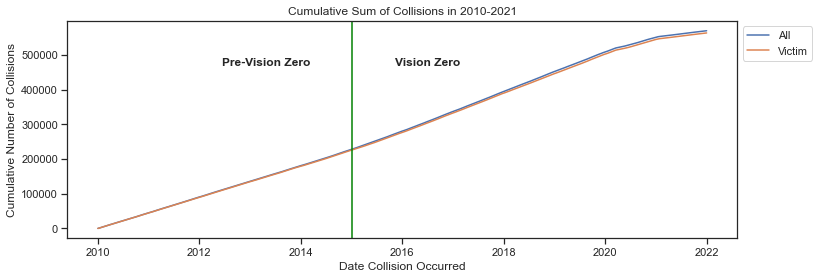

In [63]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
cal.holidays()
holidays = cal.holidays(start=dfin.dttm_occurred.dt.date.min(), end=dfin.dttm_occurred.dt.date.max())
holidays_dt = pd.to_datetime(holidays)

dfin["all"] = True

c_all = pd.DataFrame(dfin.groupby(dfin.dttm_occurred.dt.date)["all"].sum())
c_all = c_all.cumsum().rename(columns={"all":"All"})
c_all

c_victim = pd.DataFrame(dfin[["victim"]].groupby(dfin.dttm_occurred.dt.date)["victim"].sum())
c_victim = c_victim.cumsum().rename(columns={"victim":"Victim"})
c_victim

c = c_all.join(c_victim, how='left', sort=True)
c

sns.set_theme(style="whitegrid")
sns.set_style("ticks")

fig = plt.figure(figsize=(12,4))
plt.plot(c.All, label="All")
plt.plot(c.Victim, label="Victim")
plt.title("Cumulative Sum of Collisions in 2010-2021")
plt.xlabel("Date Collision Occurred")
plt.ylabel("Cumulative Number of Collisions")

plt.axvline(pd.to_datetime("2015-01-01"), color="green")
font = {'weight': 'bold',
        'size': 12}
plt.text(15500,470000, "Pre-Vision Zero", fontdict=font)
plt.text(16750,470000, "Vision Zero", fontdict=font)


plt.legend(bbox_to_anchor=(1,1,0,0))
plt.grid(False)
fig.savefig("Output/date_plots/cumsum.png")

There are no sudden jumps or increases in the number of collisions that would indicate that there are specific time periods to look examine in particular. Thus, we decided to zoom in at 2015 to see if there was any immediate effect of Vision Zero; however, there is only a steady increase in collisions. Overall, it seems like there is a victim in most collisions and this is not impacted by Vision Zero.

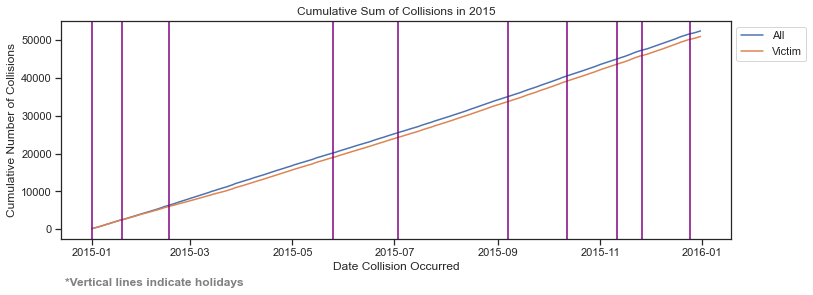

In [64]:
holidays_dt_2015 = pd.to_datetime(holidays)[50:60]
holidays_dt_2015

c_all_2015 = pd.DataFrame(dfin[dfin.dttm_occurred.dt.year==2015].groupby(dfin.dttm_occurred.dt.date)["all"].sum())
c_all_2015 = c_all_2015.cumsum().rename(columns={"all":"All"})
c_all_2015

c_victim_2015 = pd.DataFrame(dfin[(dfin.victim) & (dfin.dttm_occurred.dt.year==2015)].groupby(dfin.dttm_occurred.dt.date)["victim"].sum())
c_victim_2015 = c_victim_2015.cumsum().rename(columns={"victim":"Victim"})
c_victim_2015

c_2015 = c_all_2015.join(c_victim_2015, how='left', sort=True)
c_2015

sns.set_theme(style="whitegrid")
sns.set_style("ticks")

fig2 = plt.figure(figsize=(12,4))
plt.plot(c_2015.All, label="All")
plt.plot(c_2015.Victim, label="Victim")
plt.title("Cumulative Sum of Collisions in 2015")
plt.xlabel("Date Collision Occurred")
plt.ylabel("Cumulative Number of Collisions")
[plt.axvline(pd.to_datetime(i), color="purple") for i in holidays_dt_2015]
plt.legend(bbox_to_anchor=(1,1,0,0))
plt.grid(False)

font = {'weight': 'bold',
        "color": "gray",
        'size': 12}
plt.text(16420,-15000, "*Vertical lines indicate holidays", fontdict=font)

fig2.savefig("Output/date_plots/cumsum_2015.png",bbox_inches="tight")


There were no noticeable changes even if we were to zoom in on the year 2015 and look at the range of time around holidays (the vertical lines denote holidays).

We then decided to break it down by season, year, month, day, day of week, and time of day. Furthermore, we also wanted to examine if there are any patterns in the victims when we examine the dates/times more closely.

We decided to use the following ranges to group the `victim_age` and `time_occurred`:
   * 0-10
   * 11-20
   * 21-30
   * 31-40
   * 41-50
   * 51-60
   * 61-70
   * 71-80
   * 81-90
   * 91-98
 
For time of day, we decided to use the following groups (by military time):
   - Night: 22:00-3:59
   - Morning: 4:00-9:59
   - Noon: 10:00-15:59
   - Evening: 16-21:59

In [65]:
bins = range(0,101,10)
names = ["0-10","11-20","21-30","31-40","41-50","51-60","61-70","71-80","81-90","91-98"]
dfin["age_range"] = pd.cut(dfin.victim_age_clean,bins,labels=names)


dfin["time_occurred_int"] = dfin["time_occurred"].astype(int)

dfin['time_of_day'] = pd.cut(dfin.time_occurred_int,[0,400,1000,1600,2200,2401],
                       labels=['Night','Morning','Noon','Evening','Night '],
                            right=False).str.strip()

#double-check cut is correct.
dfin[dfin.time_occurred_int.isin([0,400,1000,1600,2200,2400])][["time_occurred_int","time_of_day"]].value_counts()


time_occurred_int  time_of_day
1600               Evening        7293
1000               Noon           5154
2200               Night          4721
400                Morning        1682
dtype: int64

In [66]:
def grapher(df, var):
    sns.set_theme(style="whitegrid")
    sns.set_style("ticks")
    
    df[["All","Victims"]].plot(kind="bar",edgecolor="black", figsize=(18,4))
    plt.ylabel("Number of Collisions")
    plt.xlabel(var)
    plt.xticks(rotation=0)
    plt.title("Number of Collisions by "+var)
    plt.legend(bbox_to_anchor=(1,1,0,0))
    plt.tight_layout()
    plt.grid(False)
    plt.savefig("Output/date_plots/"+var+"_1.png")
    
    figure, ax = plt.subplots(1,3,sharey=True,figsize=(18,4), facecolor="white")
    
    df[["0-10","11-20","21-30",
        "31-40","41-50","51-60","61-70","71-80","81-90","91-98"]].plot(ax=ax[0], 
                                                                       kind="bar",
                                                                       edgecolor="black",
                                                                       stacked=True,
                                                                      color = ["red",
                                                                               "orange",
                                                                               "yellow",
                                                                               "green",
                                                                               "blue",
                                                                              "indigo",
                                                                               "olive",
                                                                               "brown",
                                                                              "violet",
                                                                              "gray"])
    
    ax[0].legend(bbox_to_anchor=(0,0,.4,-.25))
    ax[0].set_title("Number of Collisions by Victim Age")
    ax[0].set_ylabel("Number of Collisions")
    ax[0].grid(False)
    
    df[["Male",
        "Female",
        "Other/Unknown"]].plot(ax=ax[1],
                               kind="bar",
                               edgecolor="black",
                               stacked=True,
                              color = ["cyan","purple","gray"])
    
    ax[1].legend(bbox_to_anchor=(0,0,.7,-.3))
    ax[1].set_title("Number of Collisions by Victim Sex")
    ax[1].grid(False)
    
    df[['Hispanic/Latin/Mexican', 'White','Black', 'Asian',
        'Native Hawaiian/Pacific Islander','Other','Unknown']].plot(ax=ax[2],
                                             kind="bar",
                                             edgecolor="black",
                                             stacked=True,
                                             color = ["azure","yellowgreen","olive","coral",
                                                     "chocolate","plum","gray"])
    
    ax[2].legend(bbox_to_anchor=(0,0,1,-.3))
    ax[2].set_title("Number of Collisions by Victim Descent")
    ax[2].grid(False)
    
    figure.savefig("Output/date_plots/"+var+"_2.png",bbox_inches="tight")


In [67]:
# dfin.info()
dfin["year"] = dfin["dttm_occurred"].dt.year

year_a = pd.DataFrame(dfin["year"].value_counts()).rename(columns = {"year":"All"})
year_a


year_v = pd.DataFrame(dfin[dfin["victim"]]["year"].value_counts()).rename(columns = {"year":"Victims"})
year_v

year_va = dfin.groupby("year")["age_range"]\
                     .value_counts().unstack()

year_vs = dfin.groupby("year")["victim_sex_clean"]\
                     .value_counts().unstack()#\

year_vd = dfin.groupby("year")["victim_descent_clean"]\
                     .value_counts().unstack()

year = year_a.join([year_v,year_va, year_vs, year_vd])
year = year.reindex(range(2010,2022))
year

,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
2010,45098,44708,2,890,10527,8761,7771,5513,2379,911,349,38,17526,26976,205,11,2284,6234,16070,181,6285,883,12754
2011,45276,44828,0,940,10799,8807,7933,5360,2506,871,354,44,17534,26945,343,17,2355,5956,16466,200,6447,981,12398
2012,45408,45145,0,955,10968,8611,7887,5399,2596,936,328,57,17780,26757,603,19,2367,5917,16394,199,6616,1309,12314
2013,45035,44565,0,860,10668,8474,7524,5450,2605,910,320,45,17102,26703,707,9,2387,5711,16159,296,6781,1575,11538
2014,46951,46349,0,872,11439,8896,7682,5748,2706,998,334,41,18084,27304,867,12,2457,6179,16794,223,7142,1845,11514
2015,52487,51021,0,957,12652,9706,8323,6256,3089,1064,324,39,19610,30369,1014,17,2497,6528,19125,180,8296,2370,11918
2016,56532,55967,0,1022,13711,11068,8762,6807,3480,1140,332,46,21277,32851,1793,19,2471,7388,21092,201,8886,3334,12396
2017,57726,57098,0,1033,13720,11415,9064,6901,3695,1212,366,53,21466,33311,2219,14,2553,7505,22037,209,8908,3795,11896
2018,57159,56092,0,982,13513,11472,8969,7159,3772,1305,339,42,20988,32892,2043,18,2519,7448,21803,215,8394,3523,11845
2019,56628,56291,11,5159,13124,11647,8856,6945,3861,1379,353,40,20906,31729,2577,19,2569,7619,21476,231,7048,4205,11825


In [68]:
dfin["month"] = dfin["dttm_occurred"].dt.month

month_a = pd.DataFrame(dfin["month"].value_counts()).rename(columns = {"month":"All"})

month_v = pd.DataFrame(dfin[dfin["victim"]]["month"].value_counts()).rename(columns = {"month":"Victims"})

month_va = dfin.groupby("month")["age_range"]\
                     .value_counts().unstack()

month_vs = dfin.groupby("month")["victim_sex_clean"]\
                     .value_counts().unstack()#\

month_vd = dfin.groupby("month")["victim_descent_clean"]\
                     .value_counts().unstack()

month = month_a.join([month_v,month_va, month_vs, month_vd])
month = month.reindex(range(1,13))
month.rename(index = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}, inplace=True)

month

,All,Victims,21-30,31-40,41-50,51-60,61-70,11-20,71-80,81-90,91-98,0-10,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
January,46792,46210,11052,9137,7859,5738,2820,1514,1031,309,31,3,17464,27384,1150,19,2303,6141,17440,191,6679,2120,11008
February,45072,44119,10618,8894,7287,5348,2744,1432,937,280,33,4,16708,26092,1143,12,2169,5829,16674,212,6340,2170,10455
March,49025,47945,11534,9514,7908,5769,2960,1468,993,324,35,3,18015,28431,1304,18,2225,6445,18001,216,7114,2439,11217
April,45220,44740,10808,8916,7448,5364,2700,1426,932,298,36,2,16963,26400,1193,14,2088,6109,16910,182,6587,2155,10454
May,46537,46132,11065,9154,7607,5606,2812,1724,951,298,39,5,17510,27215,1188,12,2149,6462,17275,185,6732,2106,10922
June,45921,45530,10900,9043,7366,5592,2730,1765,988,297,42,3,17159,26831,1318,7,2168,6208,16840,169,6822,2240,10785
July,47524,47142,11413,9150,7734,5795,2886,1745,983,327,38,7,17579,27945,1366,17,2238,6381,17823,209,6897,2342,10920
August,49663,49299,11926,9612,8080,5971,3020,1951,993,324,41,9,18423,29149,1450,12,2287,6562,18625,210,7158,2505,11593
September,47761,47386,11325,9369,7598,5872,2860,1881,1053,304,44,2,17878,27821,1416,11,2246,6191,18036,199,6776,2507,11087
October,50967,50514,12158,10023,8177,6070,3101,2062,1082,321,41,3,19019,29631,1558,18,2326,6535,19272,226,7356,2692,11698


In [69]:
dfin["day"] = dfin["dttm_occurred"].dt.day

day_a = pd.DataFrame(dfin["day"].value_counts()).rename(columns = {"day":"All"})


day_v = pd.DataFrame(dfin[dfin["victim"]]["day"].value_counts()).rename(columns = {"day":"Victims"})

day_va = dfin.groupby("day")["age_range"]\
                     .value_counts().unstack()

day_vs = dfin.groupby("day")["victim_sex_clean"]\
                     .value_counts().unstack()#\

day_vd = dfin.groupby("day")["victim_descent_clean"]\
                     .value_counts().unstack()

day = day_a.join([day_v,day_va, day_vs, day_vd])
day = day.reindex(range(1,32))
day

,All,Victims,21-30,31-40,41-50,51-60,61-70,11-20,71-80,81-90,91-98,0-10,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
1,19355,19127,4639,3747,3017,2343,1187,677,438,117,15,1,7161,11348,521,8,891,2661,7275,61,2828,926,4353
2,18919,18736,4494,3685,2977,2340,1177,679,428,108,21,2,6981,11106,549,3,838,2623,6961,81,2719,958,4422
3,19012,18802,4449,3784,3050,2317,1178,678,458,122,10,1,7103,11077,528,6,868,2580,7093,90,2680,937,4419
4,18572,18357,4267,3651,2996,2305,1138,652,423,134,17,2,6898,10898,484,6,855,2415,7169,86,2653,894,4165
5,18794,18570,4423,3713,3010,2232,1151,689,444,109,13,1,7073,10871,531,3,912,2473,6932,76,2701,946,4401
6,18824,18613,4490,3659,3040,2261,1224,658,402,138,13,1,6967,11037,518,9,898,2573,7014,82,2754,900,4267
7,18539,18313,4339,3767,3035,2156,1134,656,401,132,17,1,6893,10827,500,4,854,2507,6876,71,2706,870,4303
8,18658,18447,4394,3589,3061,2340,1126,646,382,120,11,3,7026,10817,521,8,829,2550,6890,84,2666,950,4348
9,18891,18673,4536,3730,3005,2251,1160,672,377,136,22,1,6995,11089,520,6,830,2471,7074,87,2785,948,4366
10,18500,18287,4475,3531,2943,2187,1156,656,395,129,11,0,7030,10665,508,4,845,2483,6857,67,2732,920,4262


In [70]:
dfin["date_temp"] = dfin.month*100 + dfin.day
dfin['season'] = (pd.cut(dfin.date_temp,[0,321,621,922,1221,1300],
                       labels=['Winter','Spring','Summer','Autumn','Winter '])
                  .str.strip()
               )
dfin[["season","month"]].value_counts().sort_index()

season_a = pd.DataFrame(dfin["season"].value_counts()).rename(columns = {"season":"All"})


season_v = pd.DataFrame(dfin[dfin["victim"]]["season"].value_counts()).rename(columns = {"season":"Victims"})

season_va = dfin.groupby("season")["age_range"]\
                     .value_counts().unstack()

season_vs = dfin.groupby("season")["victim_sex_clean"]\
                     .value_counts().unstack()#\

season_vd = dfin.groupby("season")["victim_descent_clean"]\
                     .value_counts().unstack()

season = season_a.join([season_v,season_va, season_vs, season_vd])
season = season.reindex(["Spring","Summer","Autumn","Winter"])

season

,All,Victims,21-30,31-40,41-50,51-60,61-70,11-20,71-80,81-90,91-98,0-10,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
Spring,138756,137291,33054,27329,22554,16605,8355,4763,2866,917,110,11,51968,81055,3651,37,6388,18932,51400,548,20349,6518,32307
Summer,146196,145061,34983,28296,23708,17837,8778,5687,3024,939,122,19,54290,85703,4301,41,6871,19373,54852,629,21017,7440,33859
Autumn,145209,143919,34422,28516,23163,17644,9021,5558,3231,981,134,9,54407,84390,4279,55,6786,18834,54689,598,20817,7388,33672
Winter,139242,136792,32657,27114,22788,16792,8540,4486,2983,881,105,11,51374,81201,3627,45,6687,18275,51752,598,19939,6707,31950


In [71]:
dfin["day_of_week"] = dfin.dttm_occurred.dt.day_name()
dow_a = pd.DataFrame(dfin["day_of_week"].value_counts()).rename(columns = {"day_of_week":"All"})


dow_v = pd.DataFrame(dfin[dfin["victim"]]["day_of_week"].value_counts()).rename(columns = {"day_of_week":"Victims"})

dow_va = dfin.groupby("day_of_week")["age_range"]\
                     .value_counts().unstack()

dow_vs = dfin.groupby("day_of_week")["victim_sex_clean"]\
                     .value_counts().unstack()#\

dow_vd = dfin.groupby("day_of_week")["victim_descent_clean"]\
                     .value_counts().unstack()


dow = dow_a.join([dow_v,dow_va, dow_vs, dow_vd])
dow = dow.reindex(["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"])

dow

,All,Victims,21-30,31-40,41-50,51-60,61-70,11-20,71-80,81-90,91-98,0-10,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
Sunday,74980,74047,18373,14173,11484,8311,4050,3039,1350,405,55,4,25624,45562,2458,21,3193,9901,28943,308,11127,4338,15674
Monday,78615,77768,18257,15407,12855,9779,4915,2673,1716,521,63,10,29449,45827,2112,25,3745,10446,29222,337,11700,3734,18075
Tuesday,80093,79237,18647,15958,13281,10111,5017,2743,1858,545,84,6,31005,45774,2089,20,3936,10603,29418,351,11417,3625,19382
Wednesday,80734,79908,18990,16040,13243,10155,5166,2748,1812,572,68,5,31097,46317,2134,24,3847,10715,29430,330,11572,3773,19729
Thursday,82070,81170,19145,16225,13651,10069,5223,2863,1843,569,70,8,31268,47327,2159,31,3949,10896,29903,345,11627,3790,20075
Friday,90360,89414,21732,17519,14741,11065,5666,3266,1888,619,74,8,34403,52178,2393,27,4286,11985,34011,343,12757,4295,21141
Saturday,82551,81519,19972,15933,12958,9388,4657,3162,1637,487,57,9,29193,49364,2513,30,3776,10868,31766,359,11922,4498,17712


In [72]:
tod_a = pd.DataFrame(dfin["time_of_day"].value_counts()).rename(columns = {"time_of_day":"All"})


tod_v = pd.DataFrame(dfin[dfin["victim"]]["time_of_day"].value_counts()).rename(columns = {"time_of_day":"Victims"})

tod_va = dfin.groupby("time_of_day")["age_range"]\
                     .value_counts().unstack()

tod_vs = dfin.groupby("time_of_day")["victim_sex_clean"]\
                     .value_counts().unstack()#\

tod_vd = dfin.groupby("time_of_day")["victim_descent_clean"]\
                     .value_counts().unstack()

tod = tod_a.join([tod_v,tod_va, tod_vs, tod_vd])
tod = tod.reindex(["Morning","Noon","Evening","Night"])
tod

,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
Morning,100403,99302,2,2940,21737,20768,17673,13091,6170,2165,632,85,38974,57123,2679,32,4749,12856,40388,425,13574,4821,21781
Noon,184739,182939,9,5904,40570,35590,31092,25060,13885,5554,1855,217,72939,104993,4182,50,9165,25612,66023,764,25837,7616,46783
Evening,193179,191272,31,7318,48594,38509,31090,23150,11528,3594,1058,144,73851,111830,4875,67,9418,25830,74169,844,26706,8582,44658
Night,91082,89550,8,4332,24215,16388,12358,7577,3111,791,173,25,26275,58403,4122,29,3400,11116,32113,340,16005,7034,18566


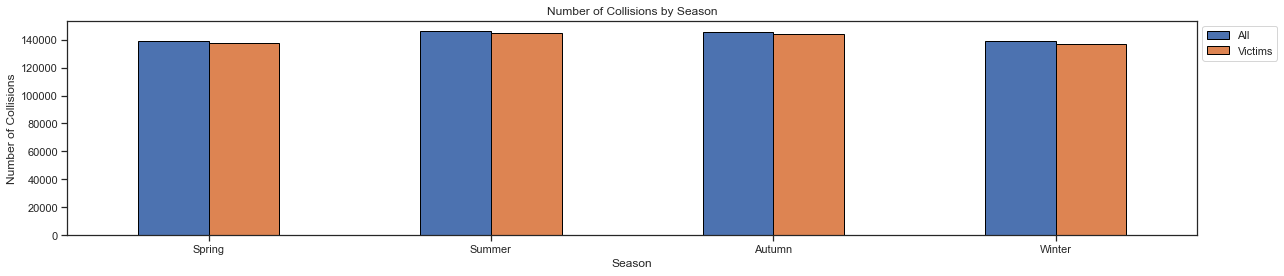

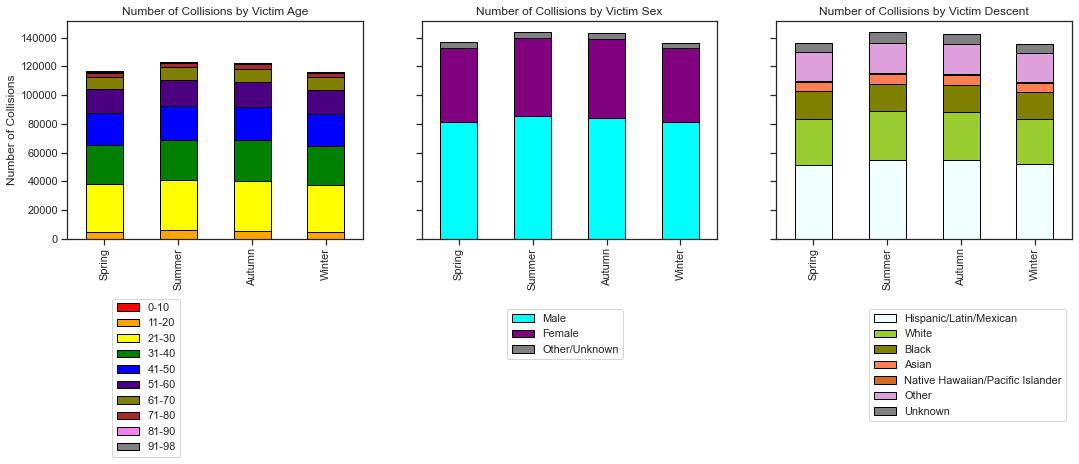

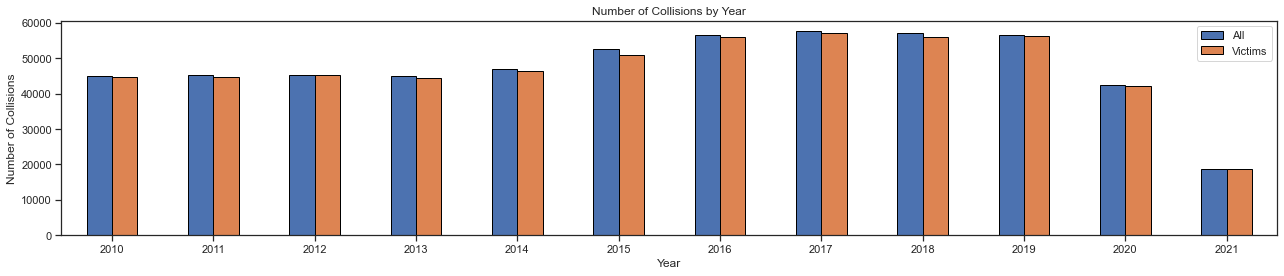

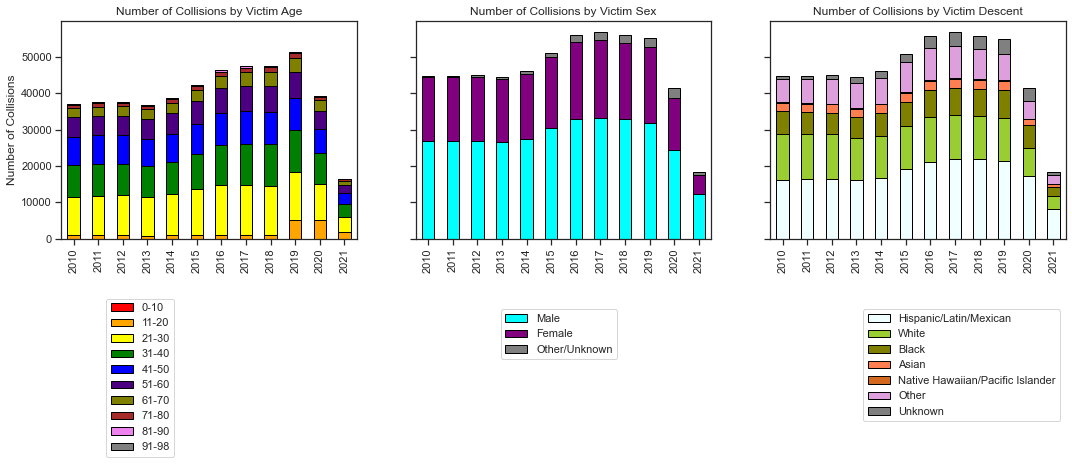

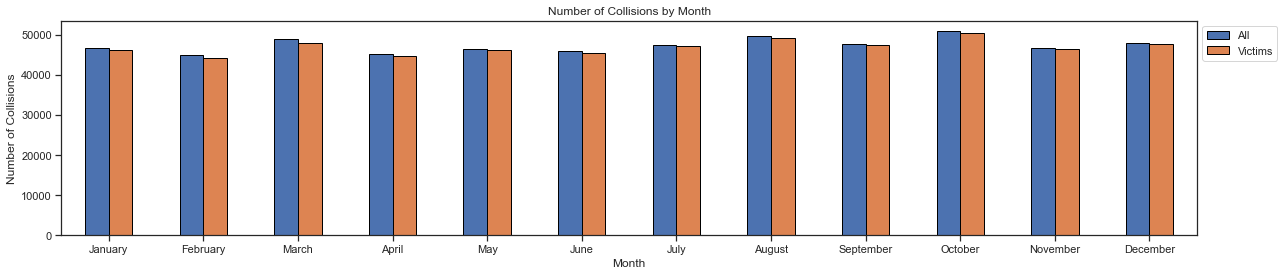

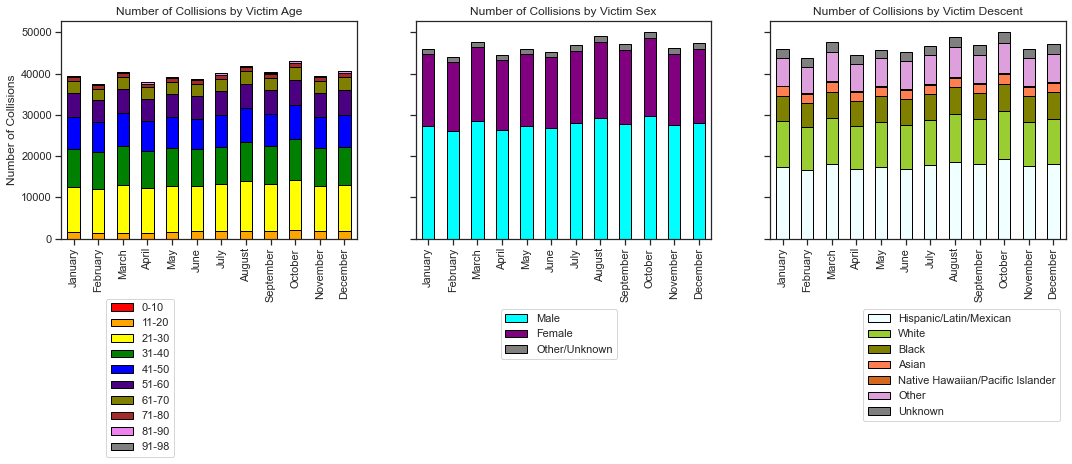

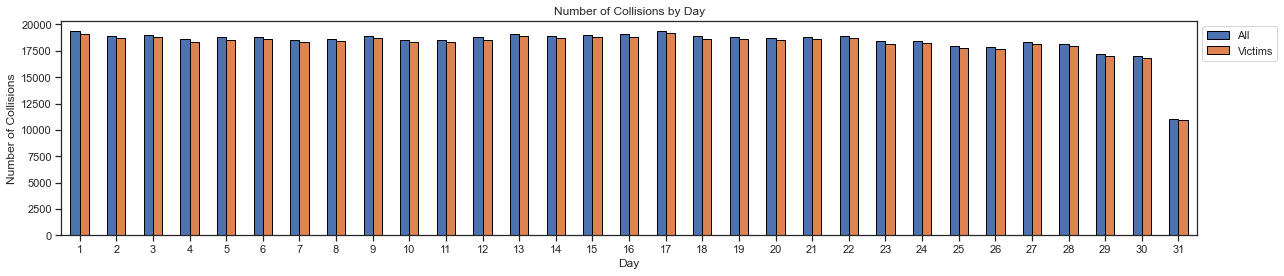

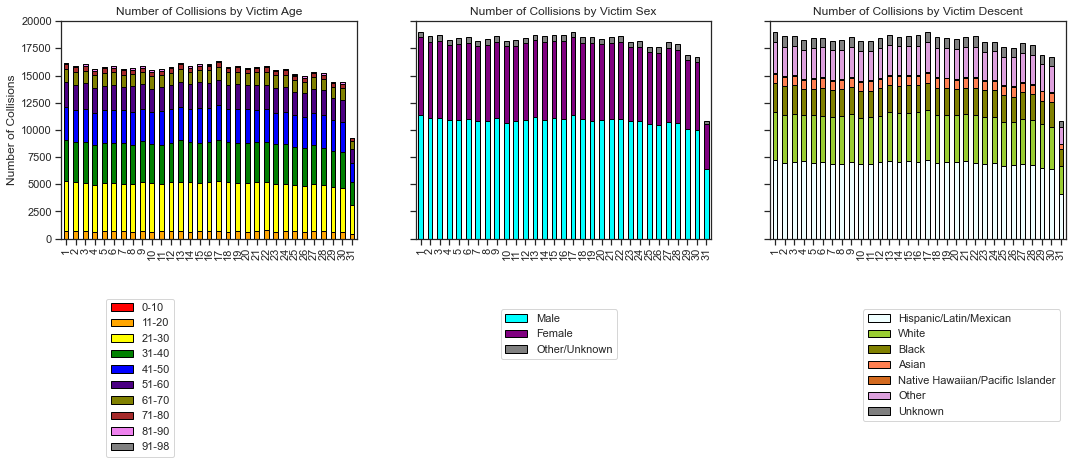

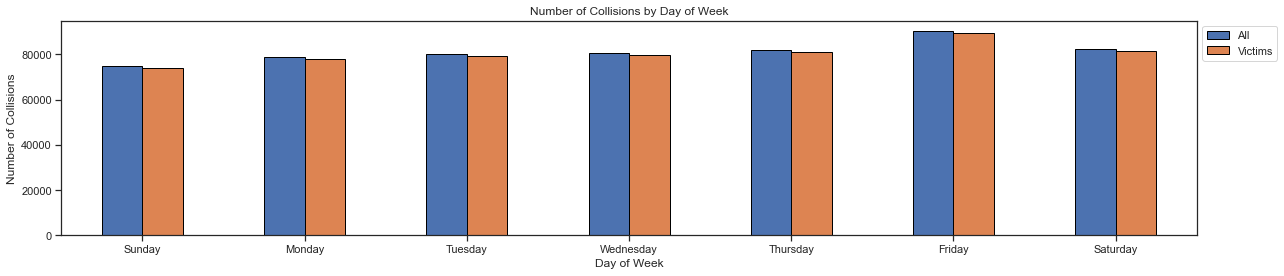

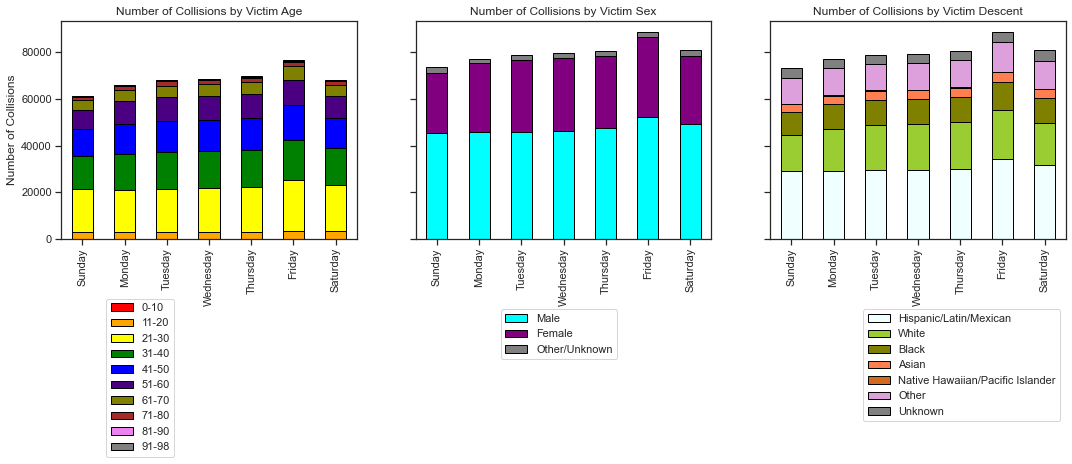

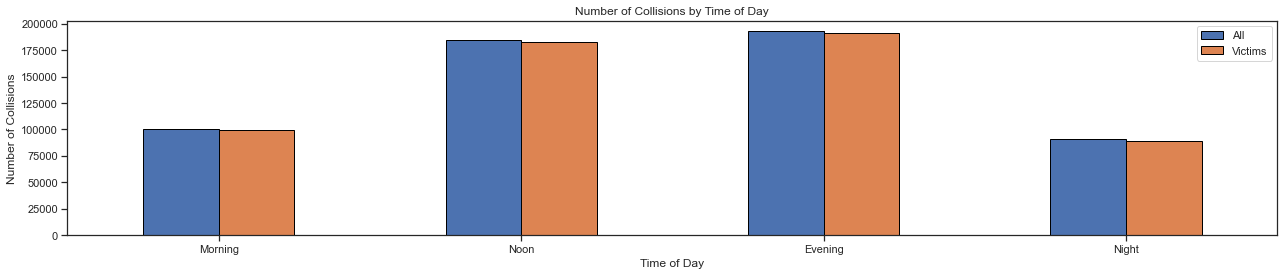

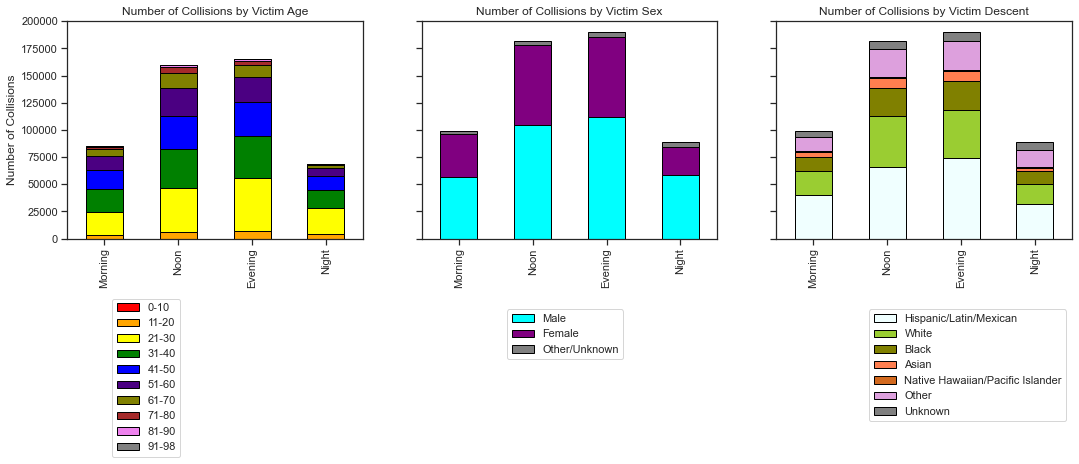

In [73]:
grapher(season,"Season")
grapher(year,"Year")
grapher(month,"Month")
grapher(day,"Day")
grapher(dow,"Day of Week")
grapher(tod,"Time of Day")

When looking at the graphs:
   * it appears that collisions **remained steady across seasons** and this is consistent with the cumulative sum graph (decided not to add into report because it is only reiterating information)
   * collisions have **increased since 2015** 
   * the collisions are **not dependent on month** (decided to not add into report since it is more interesting to focus on the year for Vision Zero)
   * there less collisions on the 31, but this could possibly be because there are months when there aren't 31 days (decided to not add into report since it is more interesting to focus on the year for Vision Zero)
   * most collisions occur during **noon and evening** (other graphs may be more interesting)
   * most collisions occur during **Friday** (decided to not add into report since it is more interesting to focus on the year for Vision Zero).
   
Most of the collisions have victims, and this is not dependent on date or time. We can examine the victims by looking at their sex, age, and descent. It looks like the victims are usually:
   * 21-30 year olds
   * male
   * Hispanic/Latin/Mexican

## MO Codes - Ben

Using the MO Codes for each collision to identify injuries, charges, and types of collisions.

### Merge in MO code descriptions and pivot long

In [74]:
# Pivot long
molist = [f'mo_code_{i}' for i in range(10)]
dfin[molist] = dfin["mo_codes"].str.split(" ", expand=True)

dfin_mo_long = pd.melt(dfin, id_vars=["dr_number"], value_vars = molist)
dfin_mo_long.columns = ["dr_number","orig_var","mo_code"]
dfin_mo_long.drop(columns=['orig_var'], inplace=True)
print("Shape of long df:", dfin_mo_long.shape)
dfin_mo_long.head()


Shape of long df: (5694030, 2)


,dr_number,mo_code
0,190319651,3036
1,190319680,3037
2,190413769,3101
3,190127578,0605
4,190319695,0605


In [75]:
# NA rows
dfin_mo_long.loc[dfin_mo_long.mo_code.isna()].shape
dfin_mo_long.loc[dfin_mo_long.mo_code.isna()].mo_code.value_counts(dropna=False)

# Drop NA rows
dfin_mo_long.dropna(subset=["mo_code"], inplace=True)
dfin_mo_long.mo_code.value_counts()
dfin_mo_long[["dr_number","mo_code"]].value_counts() #there are unique dr_numbers to mo_codes.

dr_number  mo_code
100101322  1402       1
180717061  4007       1
180717011  3101       1
           3401       1
           3701       1
                     ..
151227518  3004       1
           3026       1
           3101       1
           4025       1
222006395  4027       1
Length: 3161419, dtype: int64

In [76]:
# Import MO Codes Dict
mo_codes_dict = pd.read_csv("Input/MO_CODES_utf8.csv", header=None)
mo_codes_dict.drop(2, axis=1, inplace=True)
mo_codes_dict.columns = ["mo_code", "mo_desc"]

#zero fill the mo_codes so it will be a better join with the rest of the dataset.
mo_codes_dict.mo_code = mo_codes_dict.mo_code.astype(str).str.zfill(4)
mo_codes_dict.head()

,mo_code,mo_desc
0,0100,Suspect Impersonate
1,0101,Aid victim
2,0102,Blind
3,0103,Crippled
4,0104,Customer


In [77]:
# Join MO Description with codes
dfin_mo_desc = pd.merge(dfin_mo_long,mo_codes_dict, left_on="mo_code", right_on="mo_code", how="left")
print("mocodes desc:", dfin_mo_desc.shape)

dfin_mo_desc[["mo_code","mo_desc"]].value_counts()
print("number of coes that are nan:", dfin_mo_desc.mo_desc.isnull().sum())
print("MO codes that don't have a description:")
dfin_mo_desc[dfin_mo_desc.mo_desc.isnull()].mo_code.value_counts()

mocodes desc: (3161419, 3)
number of coes that are nan: 808
MO codes that don't have a description:


0947    710
3031     71
3063     15
3064      9
1505      1
2053      1
1528      1
Name: mo_code, dtype: int64

***ASSUMPTION: There are 7 MO codes which were not found in the MO_Codes.pdf file (and which we did not find more information about online). We will assume these are mistyped or transcribed and replace with null values.**

In [78]:
# Drop missing MO Codes
df_mo_clean = dfin_mo_desc.loc[~dfin_mo_desc.mo_desc.isnull(), :]
df_mo_clean.shape

# Merge back in other metadata from simplified dataframe
cols = ['dr_number', 'mo_codes', 'dttm_occurred', 'premise_description', 'address',
    'victim_age_clean', 'victim_sex_clean', 'victim_descent_clean', 
    'area_name', 'latitude', 'longitude']

dfsmall = dfin.loc[:, cols]
df = df_mo_clean.merge(dfsmall, how='left', on='dr_number', validate='many_to_one')
print("Shape of df:", df.shape)
df.head()

Shape of df: (3160611, 13)


,dr_number,mo_code,mo_desc,mo_codes,dttm_occurred,premise_description,address,victim_age_clean,victim_sex_clean,victim_descent_clean,area_name,latitude,longitude
0,190319651,3036,T/C - At Intersection - Yes,3036 3004 3026 3101 4003,2019-08-24 04:50:00,STREET,JEFFERSON BL,22.0,Male,Hispanic/Latin/Mexican,Southwest,34.0255,-118.3002
1,190319680,3037,T/C - At Intersection - No,3037 3006 3028 3030 3039 3101 4003,2019-08-30 23:20:00,STREET,JEFFERSON BL,30.0,Female,Hispanic/Latin/Mexican,Southwest,34.0256,-118.3089
2,190413769,3101,T/C - PCF (A) In the Narrative,3101 3401 3701 3006 3030,2019-08-25 05:45:00,STREET,N BROADWAY,NaN,Male,Unknown,Hollenbeck,34.0738,-118.2078
3,190127578,0605,Traffic Accident/Traffic related incident,0605 3101 3401 3701 3011 3034,2019-11-20 03:50:00,STREET,1ST,21.0,Male,Hispanic/Latin/Mexican,Central,34.0492,-118.2391
4,190319695,0605,Traffic Accident/Traffic related incident,0605 4025 3037 3004 3025 3101,2019-08-30 21:00:00,STREET,MARTIN LUTHER KING JR,49.0,Male,Black,Southwest,34.0108,-118.3182


In [79]:
# Export MO Codes actually present:
exp = df[['mo_code', 'mo_desc']].value_counts().reset_index()
exp.columns = ['MO code', 'MO description', 'count']
exp.to_csv("MO_CODES_used_in_file.csv")
exp[:20]

,MO code,MO description,count
0,3101,T/C - PCF (A) In the Narrative,417166
1,3401,T/C - Type of Collision,341282
2,3701,T/C - Movement Preceding Collision,341272
3,3004,T/C - Veh vs Veh,246991
4,3037,T/C - At Intersection - No,223697
5,3030,T/C - Hit and Run Misd,190534
6,3028,T/C - (N) Non Injury,158051
7,3026,T/C - (C) Complaint of Injury,136697
8,3036,T/C - At Intersection - Yes,119135
9,3006,T/C - Veh vs Parked Veh,107648


#### Isolate MO Codes of Interest

In [80]:
# T/C Indicator
df['mo_tc_ind'] = df.mo_desc.str.contains('^T/C', na=False)
#df.loc[df.mo_tc_ind,['mo_tc_ind', 'mo_desc']].value_counts()
df.mo_tc_ind.value_counts(dropna=False)

True     3056373
False     104238
Name: mo_tc_ind, dtype: int64

In [81]:
# How many collisions have a T/C indicator?
dfno_tc = df.groupby('dr_number')['mo_tc_ind'].sum().reset_index()
drnum_no_tc = dfno_tc.loc[dfno_tc.mo_tc_ind==0, 'dr_number'].tolist()
print("Share of collisions without T/C code:", len(drnum_no_tc) / dfin.shape[0])
find_other_codes = df.loc[df.dr_number.isin(drnum_no_tc), :]
find_other_codes.mo_desc.value_counts(dropna=False)[:20]

Share of collisions without T/C code: 0.04788348498339489


Traffic Accident/Traffic related incident                     18242
Other MO (see rpt)                                             5190
Vehicle involved                                               3609
Evidence Booked (any crime)                                    1661
Forced to masturbate suspect                                    891
Involved in traffic/accident                                    692
Susp uses vehicle                                               155
Suspect intoxicated/drunk                                       123
Narcotics (Buy-Sell-Rip)                                        117
Aged (60 & over) or blind/crippled/unable to care for self       80
Photographs                                                      72
Removes vict property                                            70
Gangs                                                            62
Riding bike                                                      51
Stranger                                        

##### What's colliding with what?

In [82]:
pat = ' vs '
df['mo_obj_vs_obj'] = df.mo_desc.str.contains(pat, na=False)
dfobj_vs_obj = df.groupby('dr_number')['mo_obj_vs_obj'].agg(sum).reset_index()
dfobj_vs_obj.mo_obj_vs_obj.value_counts()

df.loc[df.mo_obj_vs_obj==True, 'mo_desc'].value_counts()

T/C - Veh vs Veh                     246991
T/C - Veh vs Parked Veh              107648
T/C - Veh vs Ped                      31506
T/C - Veh vs Fixed Object             31275
T/C - Veh vs Bike                     18083
T/C - Veh vs M/C                       7086
T/C - Bike vs Veh                      1410
T/C - Veh vs Other Object              1369
T/C - M/C vs Veh                        532
T/C - Veh vs Veh on other roadway       505
T/C - Veh vs Non-collision              381
T/C - M/C vs Other                      369
T/C - M/C vs Fixed Object               335
T/C - Bike vs Other                     287
T/C - Veh vs Animal                     248
T/C - Veh vs Train                      154
T/C - Train vs Ped                       78
T/C - Train vs Veh                       28
T/C - Train vs Fixed Object              27
T/C - Train vs Train                     24
T/C - Train vs Bike                      12
T/C - Bike vs Train                       8
Name: mo_desc, dtype: int64

In [83]:
# Let's dig into some of the collisions with multiple codes
dr_number_3 = df.loc[df.dr_number.isin(dfobj_vs_obj[dfobj_vs_obj.mo_obj_vs_obj==3]['dr_number']), :].copy().sort_values(['dr_number', 'mo_code'])
dr_number_3.head()

,dr_number,mo_code,mo_desc,mo_codes,dttm_occurred,premise_description,address,victim_age_clean,victim_sex_clean,victim_descent_clean,area_name,latitude,longitude,mo_tc_ind,mo_obj_vs_obj
572589,120815955,3005,T/C - Veh vs Veh on other roadway,4027 3005 3007 3011 3101 3401 3701,2012-10-15 16:35:00,STREET,SEPULVEDA BL,26.0,Male,Other,West LA,34.0887,-118.4748,True,True
1027920,120815955,3007,T/C - Veh vs Train,4027 3005 3007 3011 3101 3401 3701,2012-10-15 16:35:00,STREET,SEPULVEDA BL,26.0,Male,Other,West LA,34.0887,-118.4748,True,True
1480713,120815955,3011,T/C - Veh vs Fixed Object,4027 3005 3007 3011 3101 3401 3701,2012-10-15 16:35:00,STREET,SEPULVEDA BL,26.0,Male,Other,West LA,34.0887,-118.4748,True,True
1923523,120815955,3101,T/C - PCF (A) In the Narrative,4027 3005 3007 3011 3101 3401 3701,2012-10-15 16:35:00,STREET,SEPULVEDA BL,26.0,Male,Other,West LA,34.0887,-118.4748,True,False
2335728,120815955,3401,T/C - Type of Collision,4027 3005 3007 3011 3101 3401 3701,2012-10-15 16:35:00,STREET,SEPULVEDA BL,26.0,Male,Other,West LA,34.0887,-118.4748,True,False


In [84]:
# Let's split into two columns, then create heat map
dfvs = df.loc[df.mo_obj_vs_obj==True, :].copy()
# Fix M/C abbreviation
dfvs['mo_desc'] = dfvs.mo_desc.str.replace("M/C", "Motorcycle")
dfvs['mo_desc'] = dfvs.mo_desc.str.replace("Veh", "Vehicle")
dfvs['Object 1'] = dfvs.mo_desc.apply(lambda x: x[5:x.find(' ', 6)])
dfvs['Object 2'] = dfvs.mo_desc.apply(lambda x: x[x.find(' vs ') + 4:])


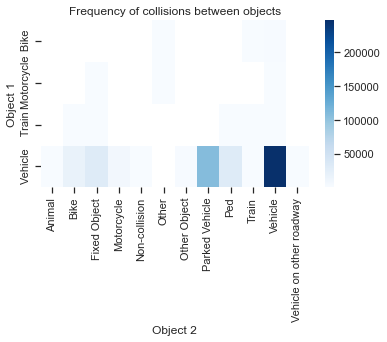

In [85]:
tit = "Frequency of collisions between objects"
dfgraph = dfvs.groupby(['Object 1', 'Object 2'])['dr_number'].size().reset_index()
dfgraph = dfgraph.pivot("Object 1", "Object 2", "dr_number")
ax = sns.heatmap(dfgraph, cmap='Blues')


ax.set_title(tit)
ax.grid(False)
fig = ax.get_figure()
fig.subplots_adjust(bottom=0.3)
fig.savefig(f"Output/mo_plots/{tit}.png", dpi=300, bbox_inches='tight')

### Charges brought against someone

In [86]:
# Charges against someone?
pat = ' DUI | Fel| Felony| Midemeanor| Misd|Unlicensed motorist'
df['mo_dui'] = df.mo_desc.str.contains(pat, na=False)
df.groupby('dr_number')['mo_dui'].agg(sum).value_counts()
df.loc[df.mo_dui==True, 'mo_desc'].value_counts()

T/C - Hit and Run Misd       190534
T/C - Hit and Run Fel         43661
T/C - Unlicensed motorist     13632
T/C - DUI Misdemeanor          3384
T/C - DUI Felony               1430
Other Felony                     18
Name: mo_desc, dtype: int64

In [87]:
# Create combination of charges
dfcharge = df.loc[df.mo_dui==1, ['dr_number', 'mo_dui', 'mo_desc']].copy()
chargedict = {'T/C - Hit and Run Misd':'Hit and run misdemeanor',
              'T/C - Hit and Run Fel':'Hit and run felony',
              'T/C - Unlicensed motorist':'Unlicensed motorist',
              'T/C - DUI Misdemeanor':'DUI misdemeanor',
              'T/C - DUI Felony':'DUI felony',
              'Other Felony':'Other felony'}
dfcharge['mo_desc_clean'] = dfcharge.mo_desc.replace(chargedict)
dfcharge = dfcharge.pivot(index='dr_number', columns='mo_desc_clean', values='mo_desc_clean')
dfcharge.fillna('', inplace=True)
dfcharge = dfcharge.loc[:,['Hit and run felony', 'DUI felony', 'Other felony', 'Hit and run misdemeanor', 'DUI misdemeanor', 'Unlicensed motorist']]

count_cols = lambda row: sum([1 for val in row.values if val!=''])
dfcharge['num_charges'] = dfcharge[list(dfcharge.columns)].apply(count_cols, axis=1)

# Use to string concatenate all charges
#cat_cols = lambda row: ', '.join([val for val in row.values if val!='' and isinstance(val, str)])

# Use to take most severge charge
cat_cols = lambda row: [val for val in row.values if val!='' and isinstance(val, str)][0]
dfcharge['combo'] = dfcharge[list(dfcharge.columns)].apply(cat_cols, axis=1)

dfcharge.sort_values(['num_charges'], inplace=True, ascending=False)
dfcharge.to_pickle('Output/pickles/df_charges.pk1')
dfcharge

mo_desc_clean,Hit and run felony,DUI felony,Other felony,Hit and run misdemeanor,DUI misdemeanor,Unlicensed motorist,num_charges,combo
dr_number,,,,,,,,
211915766,,,,Hit and run misdemeanor,DUI misdemeanor,Unlicensed motorist,3,Hit and run misdemeanor
201615688,,,,Hit and run misdemeanor,DUI misdemeanor,Unlicensed motorist,3,Hit and run misdemeanor
182115123,Hit and run felony,DUI felony,,,,Unlicensed motorist,3,Hit and run felony
211805887,Hit and run felony,DUI felony,,,,Unlicensed motorist,3,Hit and run felony
201612204,Hit and run felony,DUI felony,,,,Unlicensed motorist,3,Hit and run felony
...,...,...,...,...,...,...,...,...
151516805,,,,Hit and run misdemeanor,,,1,Hit and run misdemeanor
151516824,,,,Hit and run misdemeanor,,,1,Hit and run misdemeanor
151516860,,,,Hit and run misdemeanor,,,1,Hit and run misdemeanor


In [88]:
dfcharge_highest = dfcharge.groupby('combo').size().reset_index()
dfcharge_highest.columns = ['charges', 'count']
dfcharge_highest = dfcharge_highest.sort_values('count', ascending=False)

### Uncovering Injuries

In [89]:
# Injury
pat = 'Injury'
df['mo_injury'] = df.mo_desc.str.contains(pat, na=False)
df.groupby('dr_number')['mo_injury'].agg(sum).value_counts()

df.loc[df.mo_injury==True, 'mo_desc'].value_counts()

T/C - (N) Non Injury             158051
T/C - (C) Complaint of Injury    136697
T/C - (B) Visible Injury          61990
T/C - (A) Severe Injury           11457
T/C - (K) Fatal Injury             2345
Name: mo_desc, dtype: int64

In [90]:
# Create combination of injuries
dfinj = df.loc[df.mo_injury==1, ['dr_number', 'mo_injury', 'mo_desc']].copy()
injdict = {
    'T/C - (N) Non Injury':'Non Injury',
    'T/C - (C) Complaint of Injury':'Complaint of Injury',
    'T/C - (B) Visible Injury':'Visible Injury',
    'T/C - (A) Severe Injury':'Severe Injury',
    'T/C - (K) Fatal Injury':'Fatal Injury'}
dfinj['mo_desc_clean'] = dfinj.mo_desc.replace(injdict)
dfinj = dfinj.pivot(index='dr_number', columns='mo_desc_clean', values='mo_desc_clean')
dfinj.fillna('', inplace=True)
dfinj = dfinj.loc[:,['Fatal Injury','Severe Injury','Visible Injury','Complaint of Injury','Non Injury']]

count_cols = lambda row: sum([1 for val in row.values if val!=''])
dfinj['num_injuries'] = dfinj[list(dfinj.columns)].apply(count_cols, axis=1)

# Use to string concatenate all charges
#cat_cols = lambda row: ', '.join([val for val in row.values if val!='' and isinstance(val, str)])

# Use to take most severge charge
cat_cols = lambda row: [val for val in row.values if val!='' and isinstance(val, str)][0]
dfinj['combo'] = dfinj[list(dfinj.columns)].apply(cat_cols, axis=1)

dfinj.sort_values(['num_injuries'], inplace=True, ascending=False)

dfinj.to_pickle('Output/pickles/df_injuries.pk1')
dfinj

mo_desc_clean,Fatal Injury,Severe Injury,Visible Injury,Complaint of Injury,Non Injury,num_injuries,combo
dr_number,,,,,,,
201215962,,Severe Injury,Visible Injury,Complaint of Injury,,3,Severe Injury
191223263,,Severe Injury,Visible Injury,Complaint of Injury,,3,Severe Injury
201814666,,Severe Injury,Visible Injury,Complaint of Injury,,3,Severe Injury
201813339,,Severe Injury,Visible Injury,Complaint of Injury,,3,Severe Injury
200504224,,Severe Injury,Visible Injury,Complaint of Injury,,3,Severe Injury
...,...,...,...,...,...,...,...
152007377,,,,,Non Injury,1,Non Injury
152007375,,,,,Non Injury,1,Non Injury
152007354,,,,,Non Injury,1,Non Injury


In [91]:
dfinj_highest = dfinj.groupby('combo').size().reset_index()
dfinj_highest.columns = ['Injury', 'Count']
dfinj_highest = dfinj_highest.sort_values('Count', ascending=False)

### Charges versus Injuries

In [92]:
df1 = dfcharge[['combo']].rename(columns={'combo':'Highest charge'})
df2 = dfinj[['combo']].rename(columns={'combo':'Highest injury'})
dfcj = df1.join(df2, how='outer')
dfcj

mo_desc_clean,Highest charge,Highest injury
dr_number,,
100411905,NaN,Visible Injury
101205160,Other felony,NaN
101207633,Other felony,NaN
101222018,Other felony,NaN
101521036,NaN,Non Injury
...,...,...
221905603,Hit and run misdemeanor,Non Injury
222004142,Hit and run misdemeanor,Non Injury
222004703,Hit and run misdemeanor,Non Injury


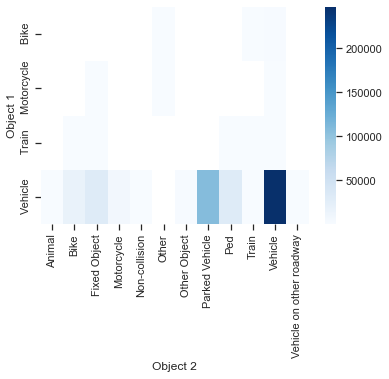

In [93]:
tit = "Frequency of collisions between objects"
dfgraph = dfvs.groupby(['Object 1', 'Object 2'])['dr_number'].size().reset_index()
dfgraph = dfgraph.pivot("Object 1", "Object 2", "dr_number")
ax = sns.heatmap(dfgraph, cmap='Blues')


Using all collisions:

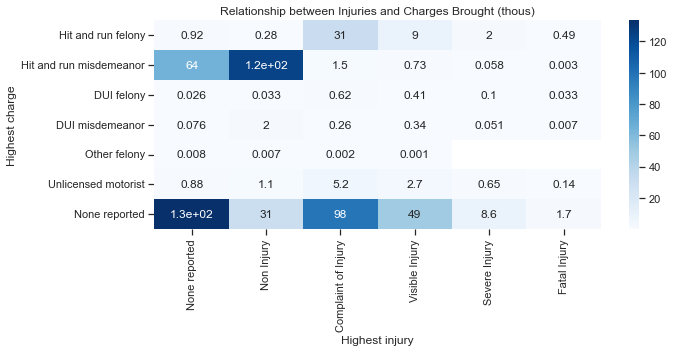

In [99]:
tit = "Relationship between Injuries and Charges Brought (thous)"
df1 = dfin[['dr_number']].copy()
df2 = dfcj.reset_index()
dfcjpercent = df1.merge(df2, on='dr_number', how='left') 
dfcjp = dfcjpercent[['Highest charge', 'Highest injury']].value_counts(dropna = False).reset_index().fillna('None reported')
dfcjp.columns = ['Highest charge', 'Highest injury', 'Count']

dfcjp['Highest charge'] = pd.Categorical(dfcjp['Highest charge'],
    categories=['Hit and run felony', 'Hit and run misdemeanor', 'DUI felony', 'DUI misdemeanor', 
    'Other felony', 'Unlicensed motorist', 'None reported'])
dfcjp['Highest injury'] = pd.Categorical(dfcjp['Highest injury'],
    categories=['None reported','Non Injury','Complaint of Injury','Visible Injury','Severe Injury','Fatal Injury'])
dfcjp['Count'] = dfcjp.Count / 1000

dfgraph = pd.pivot_table(dfcjp, values='Count', index='Highest charge', columns='Highest injury')

fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(dfgraph, cmap="Blues", annot=True)

ax.set_title(tit)
ax.grid(False)
fig = ax.get_figure()
fig.subplots_adjust(bottom=0.3)
fig.savefig(f"Output/mo_plots/{tit}.png", dpi=300, bbox_inches='tight')

### Looking by hour

Time slots (6 hours slots):
- Morning: 4-10
- Midday: 10-4
- Evening: 4-10
- Nighttime: 10-4

In [100]:
df1 = dfin[['dr_number', 'dttm_occurred']].copy()
df2 = dfcj.reset_index()
dftime = df1.merge(df2, on='dr_number', how='left') #.fillna('None reported')
print("Shape of dftime:", dftime.shape)
dftime['time_occurred'] = dftime.dttm_occurred.dt.time
dftime['time_occurred'] = dftime.time_occurred.apply(lambda t: int(str(t)[:2] + str(t)[3:5]))
dftime['Time of day'] = pd.cut(dftime.time_occurred, 
    bins=(0, 400, 1000, 1600, 2200, 2400),
    labels=('Night', 'Morning', 'Noon', 'Evening', 'Night2'))
dftime['Time of day'] = dftime['Time of day'].replace('Night2', 'Night')
dftime

Shape of dftime: (569403, 4)


,dr_number,dttm_occurred,Highest charge,Highest injury,time_occurred,Time of day
0,190319651,2019-08-24 04:50:00,NaN,Complaint of Injury,450,Morning
1,190319680,2019-08-30 23:20:00,Hit and run misdemeanor,Non Injury,2320,Night
2,190413769,2019-08-25 05:45:00,Hit and run misdemeanor,NaN,545,Morning
3,190127578,2019-11-20 03:50:00,NaN,NaN,350,Night
4,190319695,2019-08-30 21:00:00,NaN,Visible Injury,2100,Evening
...,...,...,...,...,...,...
569398,221905481,2021-02-05 13:25:00,NaN,Non Injury,1325,Noon
569399,221605396,2021-12-15 01:00:00,Hit and run misdemeanor,Non Injury,100,Night
569400,221206384,2021-02-14 14:20:00,Unlicensed motorist,Severe Injury,1420,Noon
569401,210415810,2021-12-12 21:30:00,DUI felony,Complaint of Injury,2130,Evening


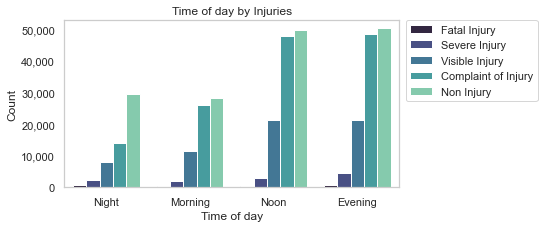

In [101]:
tit = 'Time of day by Injuries'
dfgraph = dftime.groupby(['Highest injury','Time of day']).size().reset_index()
dfgraph.rename(columns={0:'Count'}, inplace=True)
dfgraph.sort_values(['Highest injury'], inplace=True, ascending=False)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x="Time of day", y="Count", hue='Highest injury', 
    data=dfgraph, palette='mako', order = ['Night', 'Morning', 'Noon', 'Evening'],
    hue_order=['Fatal Injury', 'Severe Injury', 'Visible Injury', 'Complaint of Injury', 'Non Injury'])
ax.tick_params(axis='x', labelrotation = 0)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_title(tit)
ax.grid(False)
fig = ax.get_figure()
fig.subplots_adjust(bottom=0.3)
fig.savefig(f"Output/mo_plots/{tit}.png", dpi=300, bbox_inches='tight')

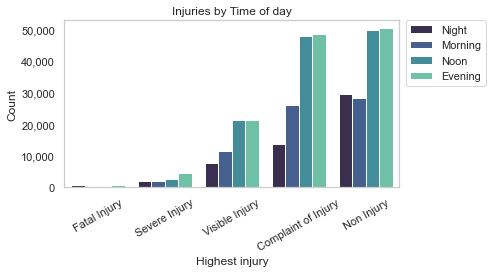

In [102]:
dfgraph = dftime.groupby(['Highest charge', 'Highest injury', 'Time of day']).size().reset_index()
dfgraph.rename(columns={0:'Count'}, inplace=True)
dfgraph

tit = 'Injuries by Time of day'
dfgraph = dftime.groupby(['Highest injury','Time of day']).size().reset_index()
dfgraph.rename(columns={0:'Count'}, inplace=True)
dfgraph.sort_values(['Highest injury'], inplace=True, ascending=False)

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.barplot(x='Highest injury', y="Count", hue="Time of day", 
    data=dfgraph, palette='mako', hue_order = ['Night', 'Morning', 'Noon', 'Evening'],
    order=['Fatal Injury', 'Severe Injury', 'Visible Injury', 'Complaint of Injury', 'Non Injury'])
ax.tick_params(axis='x', labelrotation = 30)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_title(tit)
ax.grid(False)
fig = ax.get_figure()
fig.subplots_adjust(bottom=0.3)
fig.savefig(f"Output/mo_plots/{tit}.png", dpi=300, bbox_inches='tight')

### Fatal Collisions by year

In [103]:
dfdate = dftime.copy()
dfdate['month'] = dfdate.dttm_occurred.dt.month
dfdate['day'] = dfdate.dttm_occurred.dt.day
dfdate['year'] = dfdate.dttm_occurred.dt.year
dfdate['dayofyear'] = dfdate.dttm_occurred.dt.dayofyear
dfdate['date'] = dfdate.apply(lambda row: '2020-'+str(row.month)+'-'+str(row.day), axis=1)
dfdate['date'] = pd.to_datetime(dfdate.date, format='%Y-%m-%d')
dfdate

,dr_number,dttm_occurred,Highest charge,Highest injury,time_occurred,Time of day,month,day,year,dayofyear,date
0,190319651,2019-08-24 04:50:00,NaN,Complaint of Injury,450,Morning,8,24,2019,236,2020-08-24
1,190319680,2019-08-30 23:20:00,Hit and run misdemeanor,Non Injury,2320,Night,8,30,2019,242,2020-08-30
2,190413769,2019-08-25 05:45:00,Hit and run misdemeanor,NaN,545,Morning,8,25,2019,237,2020-08-25
3,190127578,2019-11-20 03:50:00,NaN,NaN,350,Night,11,20,2019,324,2020-11-20
4,190319695,2019-08-30 21:00:00,NaN,Visible Injury,2100,Evening,8,30,2019,242,2020-08-30
...,...,...,...,...,...,...,...,...,...,...,...
569398,221905481,2021-02-05 13:25:00,NaN,Non Injury,1325,Noon,2,5,2021,36,2020-02-05
569399,221605396,2021-12-15 01:00:00,Hit and run misdemeanor,Non Injury,100,Night,12,15,2021,349,2020-12-15
569400,221206384,2021-02-14 14:20:00,Unlicensed motorist,Severe Injury,1420,Noon,2,14,2021,45,2020-02-14
569401,210415810,2021-12-12 21:30:00,DUI felony,Complaint of Injury,2130,Evening,12,12,2021,346,2020-12-12


In [104]:
cols = ['Fatal Injury']
dffatal = dfdate.loc[dfdate['Highest injury'].isin(cols) & (dfdate['year']!=2022),:].copy()
dffatal = dffatal.groupby(['year']).size().reset_index()
dffatal.rename(columns={0:'count'}, inplace=True)
dffatal

,year,count
0,2011,59
1,2012,162
2,2013,198
3,2014,206
4,2015,186
5,2016,261
6,2017,247
7,2018,246
8,2019,247
9,2020,242


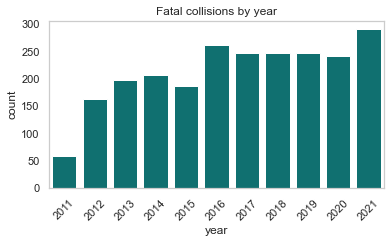

In [105]:
tit = "Fatal collisions by year"
sns.set_theme(style="whitegrid")
sns.color_palette("mako", as_cmap=True)
ax = sns.barplot(x="year", y="count", data=dffatal, color='teal')
ax.tick_params(axis='x', labelrotation = 45)
ax.set_title(tit)
ax.grid(False)
fig = ax.get_figure()
fig.subplots_adjust(bottom=0.3)
fig.savefig(f"Output/mo_plots/{tit}.png", dpi=300, bbox_inches='tight')